In [1]:
#coding:utf-8
# 载入必要的packages
import numpy as np
import pandas as pd
import time
import datetime
import keras
import keras.backend as K
from scipy import stats
from sklearn.externals import joblib
from matplotlib import pyplot as plt
plt.rcParams[u'font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from scipy.optimize import curve_fit
from sklearn import svm
#import tsfresh as tsf
from tqdm import tqdm_notebook
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn import linear_model
%matplotlib inline

Using TensorFlow backend.
C:\Software\Programming\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
'''
自定义函数区
'''
# 一些统计上的细节
def printModelDeviation(pred,test):
    pred_round=pred.astype(float).round()
    dt=pred_round-test
    dt.astype(float)
    print('提前预测百分比:',np.sum([int(i<0) for i in dt ])/dt.count(),' 延迟预测百分比',np.sum([int(i>0) for i in dt ])/dt.count()),' 准确预测百分比',np.sum([int(i==0) for i in dt ])/dt.count()
    print('以下预测均不包含前面的区间')
    print('准确预测比例:',np.sum([int(i==0) for i in dt ])/dt.count())
    print('提前预测一天比例:',np.sum([int(i==-1) for i in dt ])/dt.count(),'延迟预测一天比例:',np.sum([int(i==1) for i in dt ])/dt.count())
    print('提前预测五天比例:',np.sum([int(i>=-5 and i<-1) for i in dt ])/dt.count(),'延迟预测五天比例:',np.sum([int(i>1 and i<=5) for i in dt ])/dt.count())
    print('提前预测十天比例:',np.sum([int(i>=-10 and i<-5) for i in dt ])/dt.count(),'延迟预测十天比例:',np.sum([int(i>5 and i<=10) for i in dt ])/dt.count())
    print('提前预测半个月比例:',np.sum([int(i>=-15 and i<-10) for i in dt ])/dt.count(),'延迟预测半个月比例:',np.sum([int(i>10 and i<=15) for i in dt ])/dt.count())
    print('提前预测一个月比例:',np.sum([int(i>=-30 and i<-15) for i in dt ])/dt.count(),'延迟预测一个月比例:',np.sum([int(i>15 and i<=30) for i in dt ])/dt.count())
    print('Mean absolute error',mean_absolute_error(pred,test))
    print('Mean absolute error after round',mean_absolute_error(pred_round,test))
    print('Mean square error after round',mean_squared_error(pred_round,test))
    print('R2 after round',r2_score(pred_round,test))
    print('R2 before round',r2_score(pred,test))
    plt.subplot(1,2,1)
    plt.scatter(list(range(len(test))),test,label='测试数据真实值',alpha=0.2)
    plt.scatter(list(range(len(test))),pred,label='测试数据预测值',alpha=0.2)
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter(range(len(dt)),dt)
    plt.title('取整后误差散点图')

In [ ]:
# 部署环境以后重新加载数据
#lift=joblib.load('lift.asv') #其实只要用这个就够了的，lift为全国电梯去重排序以后总数据集
#lift_TF=joblib.load('lift_TF.asv')# TF梯，为lift数据集子集
lift_series_dict=joblib.load('lift_series_dict.asv') #电梯故障时间点序列
lift_time_series_dict=joblib.load('lift_time_series_dict.asv') #电梯故障时间间隔序列
lift_recur_train_table=joblib.load('lift_recur_train_table.asv') # 历史维修统计性信息生成的训练数据表
# 用于模型对比的相同的训练-测试数据集
x_train=joblib.load('x_train_notsfresh_intervalPredict_0220.asv')
x_test=joblib.load('x_test_notsfresh_intervalPredict_0220.asv')
y_train=joblib.load('y_train_notsfresh_intervalPredict_0220.asv')
y_test=joblib.load('y_test_notsfresh_intervalPredict_0220.asv')
# 电梯部件
components_dict=joblib.load('components_dict.asv')
components_dict_re=joblib.load('component_dict_re.asv')
lift_recur_train_table_correct=joblib.load('lift_recur_train_table_correct.asv') # 最终使用的历史维修统计性信息生成的训练数据表，因为此前的lift_recur_train_table的结果太好了，，有问题，发现还是变成故障时间点的预测
lift_comp_series_dict=joblib.load('lift_comp_series_dict.asv')
lift_comp_recur_train_table=joblib.load('lift_comp_recur_train_table.asv')
model=joblib.load('model_lstm_100epoch_20190115.asv') #lstm模型
# 模型评估
def predict_and_score(model, X, Y):
    pred=model.predict(X)
    score=np.sqrt(mean_squared_error(Y,pred))
    R=model.score(X,Y)
    return (score,pred,R)

# 虹桥数据读取与检查

In [2]:
# 数据读取
# 先检查虹桥机场的数据
callout_hq_2010=pd.read_csv('C:/PersonalAgenda/BachelorThesis/callout_data_hq/callouts2010.csv')
callout_hq_2014_1=pd.read_csv('C:/PersonalAgenda/BachelorThesis/callout_data_hq/callouts2014_1.csv')
callout_hq_2014_2=pd.read_csv('C:/PersonalAgenda/BachelorThesis/callout_data_hq/callouts2014_2.csv')


## 检查数据

In [9]:
callout_hq_2010.head(5)

,branch,callout_no,date,site_no,site_name,equip_id,equip_no,type,failure_desc,received_time,...,reason,failure_part,action,equip_status,fitter_no,repair_id,register,error_code,caller,remark
0,SH,NaN,2010/3/16,33921086,虹桥枢纽西航站楼,LP5,NaN,直梯,困人 Entrapment,17:26,...,NaN,230板 230 board,更换 replaced,01:正常运行,姚珺,2016662,周欣欣,NaN,4人，5分钟，通力放人，无抱怨，在工地。,NaN
1,SH,NaN,2010/3/16,33921086,虹桥枢纽西航站楼,LP6,NaN,直梯,不运行 doesn't work,9:08,...,NaN,厅门地坎 landing door sill,清洁 Clean,01:正常运行,SH0127,2016666,陶琴意,NaN,NaN,NaN
2,SH,NaN,2010/3/17,33921086,虹桥枢纽东交通广场,EV30,NaN,E40,不运行 doesn't work,2:40,...,NaN,电动机热敏电阻 thermistor,更换 replaced,01:正常运行,SH0226,2016664,彭臣,NaN,NaN,NaN
3,SH,NaN,2010/3/17,33921086,虹桥枢纽西航站楼,LP2,NaN,直梯,不运行 doesn't work,14:57,...,NaN,厅门地坎 landing door sill,清洁 Clean,01:正常运行,SH0127,2016668,彭臣,NaN,NaN,NaN
4,SH,NaN,2010/3/17,33921086,虹桥枢纽西航站楼,LG1,NaN,直梯,不运行 doesn't work,18:20,...,NaN,厅门地坎 landing door sill,清洁 Clean,01:正常运行,SH0127,2016670,袁琦,NaN,NaN,NaN


In [11]:
print(callout_hq_2014_1.head(2),'\n')
print(callout_hq_2014_2.head(2))

  branch callout_no      date  site_no site_name equip_id  equip_no type  \
0     SH     JC1840  2014/1/1   921230   京沪高铁虹桥站  FT5-A-4  30181139  E40   
1     SH     JC1843  2014/1/1   921230   京沪高铁虹桥站  FT7-A-A  30181168  E40   

            failure_desc received_time  ...   finished_time  arrived_status  \
0  不运行 Equipment Stopped          9:00  ...            9:45  12:不运行-不可由钥匙复位   
1  不运行 Equipment Stopped         13:15  ...           14:20  12:不运行-不可由钥匙复位   

  reason           failure_part action equip_status fitter_no repair_id  \
0   外部原因        梳齿板 Comb plate      清洁      01:正常运行    SH0470    142374   
1   外部原因  梳齿开关 Comb lift switch     清洁      01:正常运行    SH0470    142375   

  register remark  
0      王雨露    NaN  
1      王雨露    NaN  

[2 rows x 21 columns] 

  branch week callout_no      date  site_no site_name equip_id  equip_no type  \
0     SH  W27     KL8687  2014/7/1   921230   京沪高铁虹桥站      北10  30181046  E40   
1     SH  W27     KL6990  2014/7/1   921230   京沪高铁虹桥站       

* 为什么每一年的列数还不太一样呢？先暂时存疑
* 2014年甚至需要两个文件去hold数据，我们得筛选列吧，不然没法做分析

# 合并非虹桥机场数据

探索红虹桥数据集

In [2]:
data_11=pd.read_excel('C:/PersonalAgenda/BachelorThesis/虹桥机场走修记录/虹桥机场走修记录/2014/2014.{:}/故障分析报告（直梯）/分析表2014.{:}.xlsx'.format('11','11'),
                      sheet_name=[0,4])
data_12=pd.read_excel('C:/PersonalAgenda/BachelorThesis/虹桥机场走修记录/虹桥机场走修记录/2014/2014.{:}/故障分析报告（直梯）.xlsx'.format('12'),sheet_name=[2,3])

In [20]:
len(np.where(data_11[0]['Branch']==i)[0])

1558

In [21]:
# 数据字段"branch"
a=set(data_11[0]['Branch'])
b={}
for i in a:
    b[i]=len(np.where(data_11[0]['Branch']==i)[0])

In [22]:
b # 各个分支下的电梯数量

{'XA': 1558,
 'YI': 442,
 'KM': 568,
 'PD': 839,
 'NC': 357,
 'CS': 1759,
 'JH': 361,
 'GY': 273,
 'CD': 2106,
 'WX': 967,
 'HT': 573,
 'DL': 451,
 'XM': 708,
 'KS': 706,
 'SY': 1296,
 'LZ': 111,
 'DG': 336,
 'GZ': 1022,
 'WL': 299,
 'TY': 288,
 'HK': 594,
 'NB': 621,
 'NN': 797,
 'BJ': 4238,
 'LS': 67,
 'SU': 985,
 'QD': 2459,
 'CC': 526,
 'FS': 453,
 'JX': 761,
 'XZ': 267,
 'WZ': 301,
 'TJ': 1094,
 'HZ': 1935,
 'YC': 540,
 'NJ': 1665,
 'FZ': 920,
 'SJ': 250,
 'CQ': 1579,
 'MY': 319,
 'HB': 907,
 'SZ': 1029,
 'YT': 435,
 'HF': 1516,
 'WH': 1152,
 'JN': 760,
 'SH': 1749,
 'ZZ': 1759,
 'ZH': 332}

Text(0.5,1,'城市电梯维保次数直方图')

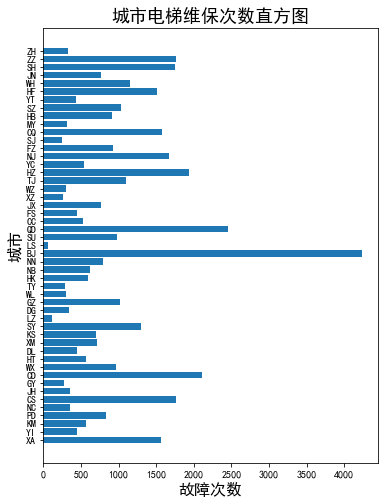

In [40]:
plt.figure(figsize=(6,8))
plt.barh(list(b.keys()),list(b.values()))
plt.xlabel('故障次数',fontsize=16)
plt.ylabel('城市',fontsize=16)
plt.title('城市电梯维保次数直方图',fontsize=18)

In [2]:
data_12=pd.read_excel('C:/PersonalAgenda/BachelorThesis/虹桥机场走修记录/虹桥机场走修记录/2014/2014.{:}/故障分析报告（直梯）.xlsx'.format('12'),sheet_name=[2,3])

In [4]:
data_12[3].head()

,Branch,Callout No,Dispatch No,Functional Location,Manuf Srl No,Order Status,Site Name,Equipment ID,Equipment No,KM01 Equip Type Code,...,Comment For Customer,Dispatch Method,合同类型,LIFS第一年?,TF？,Mono/Mini？,R VS S,R>S：Traffic?,部位,次部位
0,YT,LY3977,10211441,33400002,30346154,Finished,国奥天地二期,L7,30346154,4,...,NaN,KFM Lite,LIFS,No,TF,NaN,NaN,NaN,轿厢,照明
1,YT,LZ0662,10216483,33400003,30405845,Finished,保利●凯旋公馆,L2,30405845,4,...,NaN,KFM Lite,LIFS,No,TF,NaN,NaN,NaN,门及出入口,0
2,YT,MB5621,10234666,33400003,30405850,Finished,保利●凯旋公馆,L7,30405850,4,...,NaN,KFM Lite,LIFS,No,TF,NaN,NaN,NaN,轿厢门,0
3,YT,MB2101,10232145,33400003,30405851,Finished,保利●凯旋公馆,L8,30405851,4,...,NaN,KFM Lite,LIFS,No,TF,NaN,NaN,NaN,轿厢门,0
4,YT,MD8345,10252871,33400003,30405856,Finished,保利●凯旋公馆,L13,30405856,4,...,NaN,KFM Lite,LIFS,No,TF,NaN,NaN,NaN,轿厢,轿厢


In [32]:
# 读取非虹桥机场直梯数据
sheetName=[0,3] # 对于1-8月份 0是直梯工作表; 3是TF直梯 9，10月份则是0，5是对应的，11、12月份格式不一样
for i in range(1,9):
    s=str(i).zfill(2)
    data_dir='C:/PersonalAgenda/BachelorThesis/虹桥机场走修记录/虹桥机场走修记录/2014/2014.{:}/故障分析报告（直梯）/分析表2014.{:}.xls'.format(
    s,s)
    print('Reading file: 分析表2014.{:}.xls'.format(s))
    eq1='data_{:}=pd.read_excel(data_dir,sheetname=sheetName)'.format(s)
    exec(eq1)
data_09=pd.read_excel('C:/PersonalAgenda/BachelorThesis/虹桥机场走修记录/虹桥机场走修记录/2014/2014.{:}/故障分析报告（直梯）/分析表2014.{:}.xls'.format('09','09'),
                      sheetname=[0,4])
data_10=pd.read_excel('C:/PersonalAgenda/BachelorThesis/虹桥机场走修记录/虹桥机场走修记录/2014/2014.{:}/故障分析报告（直梯）/分析表2014.{:}.xls'.format('10','10'),
                      sheetname=[0,4])
data_11=pd.read_excel('C:/PersonalAgenda/BachelorThesis/虹桥机场走修记录/虹桥机场走修记录/2014/2014.{:}/故障分析报告（直梯）/分析表2014.{:}.xlsx'.format('11','11'),
                      sheetname=[0,4])
data_12=pd.read_excel('C:/PersonalAgenda/BachelorThesis/虹桥机场走修记录/虹桥机场走修记录/2014/2014.{:}/故障分析报告（直梯）.xlsx'.format('12'),sheetname=[2,3])

Reading file: 分析表2014.01.xls
Reading file: 分析表2014.02.xls
Reading file: 分析表2014.03.xls
Reading file: 分析表2014.04.xls
Reading file: 分析表2014.05.xls
Reading file: 分析表2014.06.xls
Reading file: 分析表2014.07.xls
Reading file: 分析表2014.08.xls


In [36]:
#数据保存
data_dict={}
for i in range(1,13):
    s=str(i).zfill(2)
    eq2='data_dict[i]=data_{:}'.format(s)
    exec(eq2)
joblib.dump(data_dict,'data_dict.asv')

['data_dict.asv']

In [37]:
print('数据集','直梯cols','TFcols')
for i in range(1,9):
    s='data_'+str(i).zfill(2)
    print(s,len(data_dict[i][0].columns),len(data_dict[i][3].columns))
print('data_09',len(data_dict[9][0].columns),len(data_dict[9][4].columns))
print('data_10',len(data_dict[10][0].columns),len(data_dict[10][4].columns))
print('data_11',len(data_dict[11][0].columns),len(data_dict[11][4].columns))
print('data_12',len(data_dict[12][2].columns),len(data_dict[12][3].columns))

数据集 直梯cols TFcols
data_01 56 59
data_02 57 59
data_03 57 60
data_04 57 59
data_05 57 59
data_06 57 59
data_07 57 59
data_08 57 59
data_09 57 59
data_10 57 59
data_11 59 59
data_12 59 59


通过具体字段的排查，发现都含有一月份的56个变量，后续变量基本没用，这个情况也适用于TF梯

In [38]:
# 先整合出全部的数据
lift=[data_01[0],data_02[0],data_03[0],data_04[0],data_05[0],data_06[0],data_07[0],data_08[0],data_09[0],data_10[0],data_11[0],data_12[2]]
lift=pd.concat(lift)
lift_TF=[data_01[3],data_02[3],data_03[3],data_04[3],data_05[3],data_06[3],data_07[3],data_08[3],data_09[4],data_10[4],data_11[4],data_12[3]]
lift_TF=pd.concat(lift_TF)

## NaN数据删除

In [71]:
len(np.where(np.isnan(lift['Component  Code']))[0])

653

In [20]:
lift=lift[pd.notnull(lift['Component  Code'])]
lift.index=range(len(lift['Receive time']))
lift_TF=lift_TF[pd.notnull(lift_TF['Component  Code'])]
lift_TF.index=range(len(lift_TF['Receive time']))

In [21]:
# 数据保存
#lift.to_csv('C:\\PersonalAgenda\\BachelorThesis\\虹桥机场走修记录\\虹桥机场走修记录\\lift.csv',encoding="utf_8")
#lift_TF.to_csv('C:\\PersonalAgenda\\BachelorThesis\\虹桥机场走修记录\\虹桥机场走修记录\\lift_TF.csv',encoding="utf_8")
joblib.dump(lift,'lift.asv')
joblib.dump(lift_TF,'lift_TF.asv')

['lift_TF.asv']

In [155]:
# 合并直梯的操作
# 筛选的字段
print('电梯走修记录总数',len(lift['Equipment No']),'去重电梯总数',len(np.unique(lift['Equipment No'])))
print('电梯城市数目',len(np.unique(lift['Branch'])))
print('电梯型号数目',len(np.unique(lift['Equipment ID'])))
print('故障原因数目',len(np.unique(lift['Reason Code'])))
print('最频繁的电梯数目',np.max(np.bincount(lift['Equipment No'])),np.argmax(np.bincount(lift['Equipment No'])))
lift['Component  Code']=lift['Component  Code'].astype(int)
print('电梯部件原因数目',len(np.unique(lift['Component  Code'])),'最频繁故障的电梯部件原因',np.max(np.bincount(lift['Component  Code'])),np.argmax(np.bincount(lift['Component  Code'])))
print('平均故障次数',np.mean(pd.value_counts(lift['Equipment No'])),'最多故障次数',np.max(pd.value_counts(lift['Equipment No'])))
print('Position数目',len(np.unique(lift['Position'])))
print('CalloutNumber',len(np.unique(lift['Callout No'])))

电梯走修记录总数 483740 去重电梯总数 115555
电梯城市数目 49
电梯型号数目 34628
故障原因数目 27
最频繁的电梯数目 110 30097056
电梯部件原因数目 296 最频繁故障的电梯部件原因 54255 3164
平均故障次数 4.186231664575311 最多故障次数 110
Position数目 5153
CalloutNumber 483728


In [28]:
lift[['Position','Reason Code','Component  Code']].head(10)

,Position,Reason Code,Component Code
0,10.0,70.0,10100.0
1,10.0,70.0,6200.0
2,10.0,70.0,13310.0
3,10.0,60.0,8120.0
4,10.0,100.0,10100.0
5,20.0,0.0,99999.0
6,60.0,70.0,12100.0
7,30.0,30.0,6000.0
8,10.0,703.0,8120.0
9,10.0,10.0,4101.0


# 尝试使用attention下的LSTM
潜在的问题
1. 如何把数据转化为序列？时间跨度应该能够有多大？
2. 历史维修记录应该可以在序列中体现出来？

解决的思路
1. 考虑从走修的第一次作为序列的起点，然后以天为时间跨度去描述生命周期？
2. 时间序列生成，以天为单位生成时间序列，而我们的预测情况就是下15天内的维修？
3. 变量构造考虑加上每一次故障的

In [7]:
# 提取每一个电梯的记录并按照receive time进行排序
# 故障部位特征等暂时先不予以考虑
lift_unq=set(lift['Equipment No'])
lift_unq=list(lift_unq)
len(lift_unq)

NameError: name 'lift' is not defined

In [54]:
lift['Receive time'][0].date()-datetime.date(2014, 1, 2)

datetime.timedelta(0)

In [53]:
lift[lift['Equipment No']==lift_unq[0]]

,Accepted Time,Action Code,Action Desc,Arrived Time,Branch,Caller Tel,Caller name,Callout No,Comment For Customer,Component Code,...,ResponseTime (min),Service Type,ServiceTime (min),Site Name,TF更换,TF？,Unnamed: 57,Unnamed: 58,Worksheet No,合同类型
28104,2014-02-06 17:10:54,50.0,修理,2014-02-06 17:11:10,SU,051266966559,李先生,JH8578,NaN,3220.0,...,31.750000,CN_KONE_CARE,1.883333,李公堤Ⅲ期地块,NaN,Other,NaN,NaN,NaN,KONE CARE STANDARD
210211,2014-07-23 17:05:28,60.0,调校,2014-07-23 17:06:47,SU,0,NaN,KR0296,NaN,6700.0,...,5.700000,CN_KONE_CARE,4.466667,李公堤Ⅲ期地块,NaN,Other,NaN,NaN,NaN,LIS
433272,2014-12-25 18:42:15,40.0,更换,2014-12-25 18:42:27,SU,0,NaN,MC4405,NaN,6210.0,...,21.816667,CN_KONE_CARE,0.783333,李公堤Ⅲ期地块,NaN,NaN,NaN,NaN,NaN,LIS
433273,2014-12-27 12:16:27,10.0,清洁,2014-12-27 12:16:37,SU,0,NaN,MC8280,NaN,3000.0,...,63.250000,CN_KONE_CARE,0.700000,李公堤Ⅲ期地块,NaN,NaN,NaN,NaN,NaN,LIS
433274,2014-12-29 13:09:28,60.0,调校,2014-12-29 13:09:38,SU,0,NaN,MD2967,NaN,3237.0,...,5.933333,CN_KONE_CARE,0.816667,李公堤Ⅲ期地块,NaN,NaN,NaN,NaN,NaN,LIS
433275,2014-12-30 17:49:07,10.0,清洁,2014-12-30 17:49:18,SU,0,NaN,MD6737,NaN,3200.0,...,3.250000,CN_KONE_CARE,1.000000,李公堤Ⅲ期地块,NaN,NaN,NaN,NaN,NaN,LIS


发现的好消息是，因为之前的数据排列是通过每个月的数据堆叠起来的，所以不用再对时间排序，但是要考虑一下不同天数所占用向量位置也不一样。
坏消息则是，走修操作的话并不是所有都是严重的，清洁更换也属于其中，这可能是后续需要考虑的！

In [106]:
# 生成每个设备的时间序列dict，记录每次时间
lift_series_dict={}
for i in range(len(lift_unq)):
    lf=lift_unq[i] #电梯设备编号
    lf_tp=list(lift[lift['Equipment No']==lf]['Receive time'])# 得到该电梯的走修时间点(time point)
    lf_ts=[0]
    for j in range(1,len(lf_tp)-1):
        try:
            time_delta=lf_tp[j].date()-lf_tp[0].date()
            lf_ts.append(time_delta.days)
        except AttributeError as e:            
            print(lf,e,'Series No.',j)
    lift_series_dict[lf]=lf_ts

30408826 'float' object has no attribute 'date' Series No. 5
30408832 'float' object has no attribute 'date' Series No. 2
30147035 'float' object has no attribute 'date' Series No. 1
30409497 'float' object has no attribute 'date' Series No. 41
30409497 'float' object has no attribute 'date' Series No. 42
30409497 'float' object has no attribute 'date' Series No. 43
30409497 'float' object has no attribute 'date' Series No. 44
30409497 'float' object has no attribute 'date' Series No. 45
30409497 'float' object has no attribute 'date' Series No. 46
30409497 'float' object has no attribute 'date' Series No. 47
30409500 'float' object has no attribute 'date' Series No. 11
30409501 'float' object has no attribute 'date' Series No. 15
30409502 'float' object has no attribute 'date' Series No. 22
30409502 'float' object has no attribute 'date' Series No. 23
30409503 'float' object has no attribute 'date' Series No. 32
30409503 'float' object has no attribute 'date' Series No. 33
30409504 'f

30414227 'float' object has no attribute 'date' Series No. 6
30414410 'float' object has no attribute 'date' Series No. 2
30152349 'float' object has no attribute 'date' Series No. 7
30152761 'float' object has no attribute 'date' Series No. 1
30414969 'float' object has no attribute 'date' Series No. 2
30414969 'float' object has no attribute 'date' Series No. 3
30415289 'float' object has no attribute 'date' Series No. 1
30415289 'float' object has no attribute 'date' Series No. 2
30273324 'float' object has no attribute 'date' Series No. 2
30416058 'float' object has no attribute 'date' Series No. 4
30416069 'float' object has no attribute 'date' Series No. 6
30416069 'float' object has no attribute 'date' Series No. 7
30416072 'float' object has no attribute 'date' Series No. 6
30416072 'float' object has no attribute 'date' Series No. 7
30012923 'float' object has no attribute 'date' Series No. 1
30416401 'float' object has no attribute 'date' Series No. 15
30416402 'float' object

30162808 'float' object has no attribute 'date' Series No. 1
30162812 'float' object has no attribute 'date' Series No. 1
30162812 'float' object has no attribute 'date' Series No. 2
30162822 'float' object has no attribute 'date' Series No. 1
30162823 'float' object has no attribute 'date' Series No. 1
30162847 'float' object has no attribute 'date' Series No. 1
30162854 'float' object has no attribute 'date' Series No. 1
30162860 'float' object has no attribute 'date' Series No. 2
30162860 'float' object has no attribute 'date' Series No. 3
30162868 'float' object has no attribute 'date' Series No. 1
30426129 'float' object has no attribute 'date' Series No. 1
30426126 'float' object has no attribute 'date' Series No. 1
30164245 'float' object has no attribute 'date' Series No. 2
30426800 'float' object has no attribute 'date' Series No. 4
30426801 'float' object has no attribute 'date' Series No. 5
30426858 'float' object has no attribute 'date' Series No. 5
30426868 'float' object 

30436126 'float' object has no attribute 'date' Series No. 25
30436126 'float' object has no attribute 'date' Series No. 26
30436126 'float' object has no attribute 'date' Series No. 27
30436127 'float' object has no attribute 'date' Series No. 47
30436128 'float' object has no attribute 'date' Series No. 29
30436128 'float' object has no attribute 'date' Series No. 30
30436128 'float' object has no attribute 'date' Series No. 31
30436129 'float' object has no attribute 'date' Series No. 28
30436129 'float' object has no attribute 'date' Series No. 29
30436135 'float' object has no attribute 'date' Series No. 27
30329491 'float' object has no attribute 'date' Series No. 3
30436952 'float' object has no attribute 'date' Series No. 3
30436953 'float' object has no attribute 'date' Series No. 2
30436958 'float' object has no attribute 'date' Series No. 9
30437060 'float' object has no attribute 'date' Series No. 1
30175750 'float' object has no attribute 'date' Series No. 1
30438114 'floa

30278669 'float' object has no attribute 'date' Series No. 1
30278680 'float' object has no attribute 'date' Series No. 4
30278680 'float' object has no attribute 'date' Series No. 5
30443759 'float' object has no attribute 'date' Series No. 1
30443762 'float' object has no attribute 'date' Series No. 1
30443763 'float' object has no attribute 'date' Series No. 1
30444509 'float' object has no attribute 'date' Series No. 6
30444511 'float' object has no attribute 'date' Series No. 4
30444513 'float' object has no attribute 'date' Series No. 8
30444518 'float' object has no attribute 'date' Series No. 11
30444519 'float' object has no attribute 'date' Series No. 5
30444519 'float' object has no attribute 'date' Series No. 6
30444519 'float' object has no attribute 'date' Series No. 7
30444519 'float' object has no attribute 'date' Series No. 8
30182405 'float' object has no attribute 'date' Series No. 10
30182405 'float' object has no attribute 'date' Series No. 11
30182405 'float' obje

30280493 'float' object has no attribute 'date' Series No. 12
30451895 'float' object has no attribute 'date' Series No. 3
30451895 'float' object has no attribute 'date' Series No. 4
30451895 'float' object has no attribute 'date' Series No. 5
30451895 'float' object has no attribute 'date' Series No. 6
30451895 'float' object has no attribute 'date' Series No. 7
30451896 'float' object has no attribute 'date' Series No. 4
30451896 'float' object has no attribute 'date' Series No. 5
30451896 'float' object has no attribute 'date' Series No. 6
30451897 'float' object has no attribute 'date' Series No. 2
30451898 'float' object has no attribute 'date' Series No. 1
30451899 'float' object has no attribute 'date' Series No. 1
30451899 'float' object has no attribute 'date' Series No. 2
30451899 'float' object has no attribute 'date' Series No. 3
30451900 'float' object has no attribute 'date' Series No. 2
30451900 'float' object has no attribute 'date' Series No. 3
30452092 'float' object

30205470 'float' object has no attribute 'date' Series No. 6
30206108 'float' object has no attribute 'date' Series No. 1
30206566 'float' object has no attribute 'date' Series No. 2
30469937 'float' object has no attribute 'date' Series No. 1
30207963 'float' object has no attribute 'date' Series No. 11
30207970 'float' object has no attribute 'date' Series No. 17
30471967 'float' object has no attribute 'date' Series No. 1
30471969 'float' object has no attribute 'date' Series No. 1
30209834 'float' object has no attribute 'date' Series No. 6
30209834 'float' object has no attribute 'date' Series No. 7
30471982 'float' object has no attribute 'date' Series No. 1
30336727 'float' object has no attribute 'date' Series No. 4
30210547 'float' object has no attribute 'date' Series No. 3
30210547 'float' object has no attribute 'date' Series No. 4
30210548 'float' object has no attribute 'date' Series No. 1
30210548 'float' object has no attribute 'date' Series No. 2
30472819 'float' objec

30077851 'float' object has no attribute 'date' Series No. 3
30219353 'float' object has no attribute 'date' Series No. 6
30219353 'float' object has no attribute 'date' Series No. 7
30219353 'float' object has no attribute 'date' Series No. 8
30219354 'float' object has no attribute 'date' Series No. 3
30219355 'float' object has no attribute 'date' Series No. 10
30219356 'float' object has no attribute 'date' Series No. 10
30219357 'float' object has no attribute 'date' Series No. 8
30219357 'float' object has no attribute 'date' Series No. 9
30219357 'float' object has no attribute 'date' Series No. 29
30219357 'float' object has no attribute 'date' Series No. 30
30219358 'float' object has no attribute 'date' Series No. 5
30219359 'float' object has no attribute 'date' Series No. 7
30219359 'float' object has no attribute 'date' Series No. 8
30219359 'float' object has no attribute 'date' Series No. 9
30219359 'float' object has no attribute 'date' Series No. 27
30219360 'float' ob

30339451 'float' object has no attribute 'date' Series No. 1
30224149 'float' object has no attribute 'date' Series No. 4
30224149 'float' object has no attribute 'date' Series No. 5
30224720 'float' object has no attribute 'date' Series No. 8
30225033 'float' object has no attribute 'date' Series No. 1
30225035 'float' object has no attribute 'date' Series No. 1
30225035 'float' object has no attribute 'date' Series No. 2
30225035 'float' object has no attribute 'date' Series No. 3
30225036 'float' object has no attribute 'date' Series No. 2
30225041 'float' object has no attribute 'date' Series No. 1
30225041 'float' object has no attribute 'date' Series No. 2
30225041 'float' object has no attribute 'date' Series No. 3
30225041 'float' object has no attribute 'date' Series No. 4
30225044 'float' object has no attribute 'date' Series No. 1
30225044 'float' object has no attribute 'date' Series No. 2
30225045 'float' object has no attribute 'date' Series No. 1
30225048 'float' object 

30230866 'float' object has no attribute 'date' Series No. 6
30230867 'float' object has no attribute 'date' Series No. 15
30230867 'float' object has no attribute 'date' Series No. 16
30230868 'float' object has no attribute 'date' Series No. 13
30231467 'float' object has no attribute 'date' Series No. 3
30231498 'float' object has no attribute 'date' Series No. 4
30231501 'float' object has no attribute 'date' Series No. 3
30231541 'float' object has no attribute 'date' Series No. 5
30231689 'float' object has no attribute 'date' Series No. 6
30231689 'float' object has no attribute 'date' Series No. 7
30132553 'float' object has no attribute 'date' Series No. 1
30445208 'float' object has no attribute 'date' Series No. 4
30445210 'float' object has no attribute 'date' Series No. 10
30445214 'float' object has no attribute 'date' Series No. 8
30232133 'float' object has no attribute 'date' Series No. 4
30232138 'float' object has no attribute 'date' Series No. 15
30232145 'float' ob

30239824 'float' object has no attribute 'date' Series No. 2
30239914 'float' object has no attribute 'date' Series No. 1
30239915 'float' object has no attribute 'date' Series No. 1
30240392 'float' object has no attribute 'date' Series No. 1
30240649 'float' object has no attribute 'date' Series No. 3
30240649 'float' object has no attribute 'date' Series No. 4
30240664 'float' object has no attribute 'date' Series No. 2
30240664 'float' object has no attribute 'date' Series No. 3
30241550 'float' object has no attribute 'date' Series No. 2
30242754 'float' object has no attribute 'date' Series No. 6
30242755 'float' object has no attribute 'date' Series No. 3
30242755 'float' object has no attribute 'date' Series No. 4
30242756 'float' object has no attribute 'date' Series No. 1
30242757 'float' object has no attribute 'date' Series No. 5
30242758 'float' object has no attribute 'date' Series No. 2
30242758 'float' object has no attribute 'date' Series No. 3
30242758 'float' object 

30246780 'float' object has no attribute 'date' Series No. 1
30246781 'float' object has no attribute 'date' Series No. 3
30246781 'float' object has no attribute 'date' Series No. 4
30246782 'float' object has no attribute 'date' Series No. 3
30246786 'float' object has no attribute 'date' Series No. 1
30246933 'float' object has no attribute 'date' Series No. 1
30083476 'float' object has no attribute 'date' Series No. 1
30083476 'float' object has no attribute 'date' Series No. 2
30083476 'float' object has no attribute 'date' Series No. 3
30083476 'float' object has no attribute 'date' Series No. 4
30083476 'float' object has no attribute 'date' Series No. 5
30083476 'float' object has no attribute 'date' Series No. 6
30135643 'float' object has no attribute 'date' Series No. 2
30248328 'float' object has no attribute 'date' Series No. 1
30248328 'float' object has no attribute 'date' Series No. 2
30248328 'float' object has no attribute 'date' Series No. 3
30248328 'float' object 

30256499 'float' object has no attribute 'date' Series No. 3
30256504 'float' object has no attribute 'date' Series No. 8
30256509 'float' object has no attribute 'date' Series No. 14
30398000 'float' object has no attribute 'date' Series No. 4
30256577 'float' object has no attribute 'date' Series No. 2
30256579 'float' object has no attribute 'date' Series No. 3
30256580 'float' object has no attribute 'date' Series No. 1
30256588 'float' object has no attribute 'date' Series No. 4
30256595 'float' object has no attribute 'date' Series No. 1
30256603 'float' object has no attribute 'date' Series No. 6
30256604 'float' object has no attribute 'date' Series No. 4
30256605 'float' object has no attribute 'date' Series No. 4
30256607 'float' object has no attribute 'date' Series No. 4
30256686 'float' object has no attribute 'date' Series No. 2
30256687 'float' object has no attribute 'date' Series No. 1
30257041 'float' object has no attribute 'date' Series No. 1
30257041 'float' object

30263881 'float' object has no attribute 'date' Series No. 4
30526031 'float' object has no attribute 'date' Series No. 1
30526040 'float' object has no attribute 'date' Series No. 3
30264592 'float' object has no attribute 'date' Series No. 1
30264612 'float' object has no attribute 'date' Series No. 1
30264612 'float' object has no attribute 'date' Series No. 2
30264615 'float' object has no attribute 'date' Series No. 9
30264618 'float' object has no attribute 'date' Series No. 1
30264618 'float' object has no attribute 'date' Series No. 2
30264618 'float' object has no attribute 'date' Series No. 3
30264618 'float' object has no attribute 'date' Series No. 4
30264618 'float' object has no attribute 'date' Series No. 5
30265292 'float' object has no attribute 'date' Series No. 1
30265293 'float' object has no attribute 'date' Series No. 1
30265295 'float' object has no attribute 'date' Series No. 3
30265295 'float' object has no attribute 'date' Series No. 4
30265644 'float' object 

30270929 'float' object has no attribute 'date' Series No. 6
30008821 'float' object has no attribute 'date' Series No. 5
30008821 'float' object has no attribute 'date' Series No. 6
30008834 'float' object has no attribute 'date' Series No. 4
30008896 'float' object has no attribute 'date' Series No. 15
30008896 'float' object has no attribute 'date' Series No. 16
30008939 'float' object has no attribute 'date' Series No. 2
30008961 'float' object has no attribute 'date' Series No. 17
30009050 'float' object has no attribute 'date' Series No. 8
30009094 'float' object has no attribute 'date' Series No. 4
30009094 'float' object has no attribute 'date' Series No. 5
30009226 'float' object has no attribute 'date' Series No. 1
30271406 'float' object has no attribute 'date' Series No. 1
30271409 'float' object has no attribute 'date' Series No. 5
30271410 'float' object has no attribute 'date' Series No. 1
30271410 'float' object has no attribute 'date' Series No. 2
30271410 'float' obje

30012474 'float' object has no attribute 'date' Series No. 5
30012512 'float' object has no attribute 'date' Series No. 7
30012512 'float' object has no attribute 'date' Series No. 8
30012512 'float' object has no attribute 'date' Series No. 9
30012512 'float' object has no attribute 'date' Series No. 10
30012530 'float' object has no attribute 'date' Series No. 1
30012856 'float' object has no attribute 'date' Series No. 1
30012866 'float' object has no attribute 'date' Series No. 1
30012866 'float' object has no attribute 'date' Series No. 2
30012866 'float' object has no attribute 'date' Series No. 3
30012921 'float' object has no attribute 'date' Series No. 1
30012921 'float' object has no attribute 'date' Series No. 2
30012922 'float' object has no attribute 'date' Series No. 2
30013131 'float' object has no attribute 'date' Series No. 12
30013273 'float' object has no attribute 'date' Series No. 12
30013273 'float' object has no attribute 'date' Series No. 27
30013274 'float' obj

30017601 'float' object has no attribute 'date' Series No. 3
30017601 'float' object has no attribute 'date' Series No. 6
30017602 'float' object has no attribute 'date' Series No. 1
30017605 'float' object has no attribute 'date' Series No. 3
30017605 'float' object has no attribute 'date' Series No. 9
30017606 'float' object has no attribute 'date' Series No. 2
30017607 'float' object has no attribute 'date' Series No. 1
30017607 'float' object has no attribute 'date' Series No. 2
30017607 'float' object has no attribute 'date' Series No. 7
30017609 'float' object has no attribute 'date' Series No. 1
30017609 'float' object has no attribute 'date' Series No. 2
30017609 'float' object has no attribute 'date' Series No. 3
30017609 'float' object has no attribute 'date' Series No. 4
30017609 'float' object has no attribute 'date' Series No. 5
30017610 'float' object has no attribute 'date' Series No. 4
30017610 'float' object has no attribute 'date' Series No. 5
30017610 'float' object 

30282353 'float' object has no attribute 'date' Series No. 4
30020220 'float' object has no attribute 'date' Series No. 4
30020221 'float' object has no attribute 'date' Series No. 7
30020221 'float' object has no attribute 'date' Series No. 8
30282449 'float' object has no attribute 'date' Series No. 4
30282483 'float' object has no attribute 'date' Series No. 3
30020480 'float' object has no attribute 'date' Series No. 2
30020480 'float' object has no attribute 'date' Series No. 3
30020480 'float' object has no attribute 'date' Series No. 6
30020487 'float' object has no attribute 'date' Series No. 3
30282810 'float' object has no attribute 'date' Series No. 1
30282810 'float' object has no attribute 'date' Series No. 2
30282810 'float' object has no attribute 'date' Series No. 3
30282936 'float' object has no attribute 'date' Series No. 3
30282936 'float' object has no attribute 'date' Series No. 4
30282937 'float' object has no attribute 'date' Series No. 1
30282937 'float' object 

30288214 'float' object has no attribute 'date' Series No. 15
30288215 'float' object has no attribute 'date' Series No. 26
30288215 'float' object has no attribute 'date' Series No. 27
30288216 'float' object has no attribute 'date' Series No. 34
30288217 'float' object has no attribute 'date' Series No. 24
30288217 'float' object has no attribute 'date' Series No. 25
30288220 'float' object has no attribute 'date' Series No. 13
30288229 'float' object has no attribute 'date' Series No. 17
30288658 'float' object has no attribute 'date' Series No. 12
30288663 'float' object has no attribute 'date' Series No. 13
30288663 'float' object has no attribute 'date' Series No. 14
30288663 'float' object has no attribute 'date' Series No. 15
30288663 'float' object has no attribute 'date' Series No. 16
30288664 'float' object has no attribute 'date' Series No. 15
30288671 'float' object has no attribute 'date' Series No. 4
30289485 'float' object has no attribute 'date' Series No. 1
30289487 '

30474685 'float' object has no attribute 'date' Series No. 2
30296281 'float' object has no attribute 'date' Series No. 4
30297461 'float' object has no attribute 'date' Series No. 6
30297462 'float' object has no attribute 'date' Series No. 1
30297467 'float' object has no attribute 'date' Series No. 1
30297646 'float' object has no attribute 'date' Series No. 3
30297647 'float' object has no attribute 'date' Series No. 4
30297648 'float' object has no attribute 'date' Series No. 1
30297651 'float' object has no attribute 'date' Series No. 1
30297651 'float' object has no attribute 'date' Series No. 2
30297654 'float' object has no attribute 'date' Series No. 1
30297654 'float' object has no attribute 'date' Series No. 2
30297664 'float' object has no attribute 'date' Series No. 1
30298624 'float' object has no attribute 'date' Series No. 1
30298627 'float' object has no attribute 'date' Series No. 1
30298628 'float' object has no attribute 'date' Series No. 1
30298630 'float' object 

30303595 'float' object has no attribute 'date' Series No. 1
30303595 'float' object has no attribute 'date' Series No. 2
30303595 'float' object has no attribute 'date' Series No. 3
30303595 'float' object has no attribute 'date' Series No. 4
30303595 'float' object has no attribute 'date' Series No. 5
30303595 'float' object has no attribute 'date' Series No. 6
30303595 'float' object has no attribute 'date' Series No. 7
30303596 'float' object has no attribute 'date' Series No. 8
30303596 'float' object has no attribute 'date' Series No. 24
30303596 'float' object has no attribute 'date' Series No. 25
30303596 'float' object has no attribute 'date' Series No. 26
30303596 'float' object has no attribute 'date' Series No. 27
30303597 'float' object has no attribute 'date' Series No. 10
30303597 'float' object has no attribute 'date' Series No. 11
30303597 'float' object has no attribute 'date' Series No. 12
30303597 'float' object has no attribute 'date' Series No. 27
30303597 'float'

30310961 'float' object has no attribute 'date' Series No. 1
30408831 'float' object has no attribute 'date' Series No. 2
30311186 'float' object has no attribute 'date' Series No. 1
30311757 'float' object has no attribute 'date' Series No. 4
30311757 'float' object has no attribute 'date' Series No. 5
30311757 'float' object has no attribute 'date' Series No. 6
30311757 'float' object has no attribute 'date' Series No. 7
30311759 'float' object has no attribute 'date' Series No. 7
30311759 'float' object has no attribute 'date' Series No. 8
30311759 'float' object has no attribute 'date' Series No. 9
30311759 'float' object has no attribute 'date' Series No. 10
30311760 'float' object has no attribute 'date' Series No. 4
30311760 'float' object has no attribute 'date' Series No. 5
30311760 'float' object has no attribute 'date' Series No. 6
30311760 'float' object has no attribute 'date' Series No. 7
30311760 'float' object has no attribute 'date' Series No. 8
30311760 'float' object

30358836 'float' object has no attribute 'date' Series No. 1
30358836 'float' object has no attribute 'date' Series No. 2
30358837 'float' object has no attribute 'date' Series No. 1
30358837 'float' object has no attribute 'date' Series No. 2
30322181 'float' object has no attribute 'date' Series No. 4
30322181 'float' object has no attribute 'date' Series No. 5
30322182 'float' object has no attribute 'date' Series No. 3
30322182 'float' object has no attribute 'date' Series No. 4
30358969 'float' object has no attribute 'date' Series No. 1
30322394 'float' object has no attribute 'date' Series No. 3
30322530 'float' object has no attribute 'date' Series No. 7
30322530 'float' object has no attribute 'date' Series No. 8
30322530 'float' object has no attribute 'date' Series No. 9
30322532 'float' object has no attribute 'date' Series No. 13
30322532 'float' object has no attribute 'date' Series No. 14
30322539 'float' object has no attribute 'date' Series No. 2
30322539 'float' objec

30067795 'float' object has no attribute 'date' Series No. 3
30067795 'float' object has no attribute 'date' Series No. 4
30067797 'float' object has no attribute 'date' Series No. 2
30067797 'float' object has no attribute 'date' Series No. 3
30329945 'float' object has no attribute 'date' Series No. 2
30329946 'float' object has no attribute 'date' Series No. 1
30329947 'float' object has no attribute 'date' Series No. 2
30329949 'float' object has no attribute 'date' Series No. 5
30329953 'float' object has no attribute 'date' Series No. 4
30329953 'float' object has no attribute 'date' Series No. 5
30329959 'float' object has no attribute 'date' Series No. 2
30068494 'float' object has no attribute 'date' Series No. 5
30068494 'float' object has no attribute 'date' Series No. 6
30068494 'float' object has no attribute 'date' Series No. 7
30068494 'float' object has no attribute 'date' Series No. 8
30068494 'float' object has no attribute 'date' Series No. 9
30068494 'float' object 

30074443 'float' object has no attribute 'date' Series No. 1
30336706 'float' object has no attribute 'date' Series No. 3
30336712 'float' object has no attribute 'date' Series No. 7
30336714 'float' object has no attribute 'date' Series No. 5
30336718 'float' object has no attribute 'date' Series No. 6
30336730 'float' object has no attribute 'date' Series No. 5
30336730 'float' object has no attribute 'date' Series No. 6
30336738 'float' object has no attribute 'date' Series No. 3
30074804 'float' object has no attribute 'date' Series No. 1
30074828 'float' object has no attribute 'date' Series No. 1
30074828 'float' object has no attribute 'date' Series No. 2
30074828 'float' object has no attribute 'date' Series No. 3
30074829 'float' object has no attribute 'date' Series No. 1
30074829 'float' object has no attribute 'date' Series No. 2
30074829 'float' object has no attribute 'date' Series No. 3
30074829 'float' object has no attribute 'date' Series No. 4
30074830 'float' object 

30339422 'float' object has no attribute 'date' Series No. 25
30339423 'float' object has no attribute 'date' Series No. 5
30339424 'float' object has no attribute 'date' Series No. 2
30339425 'float' object has no attribute 'date' Series No. 1
30339425 'float' object has no attribute 'date' Series No. 2
30339425 'float' object has no attribute 'date' Series No. 3
30339427 'float' object has no attribute 'date' Series No. 4
30339427 'float' object has no attribute 'date' Series No. 5
30339428 'float' object has no attribute 'date' Series No. 1
30339428 'float' object has no attribute 'date' Series No. 2
30339428 'float' object has no attribute 'date' Series No. 5
30339429 'float' object has no attribute 'date' Series No. 9
30339430 'float' object has no attribute 'date' Series No. 1
30339435 'float' object has no attribute 'date' Series No. 1
30339435 'float' object has no attribute 'date' Series No. 2
30339435 'float' object has no attribute 'date' Series No. 4
30339437 'float' object

30343709 'float' object has no attribute 'date' Series No. 6
30343712 'float' object has no attribute 'date' Series No. 1
30343712 'float' object has no attribute 'date' Series No. 2
30343712 'float' object has no attribute 'date' Series No. 3
30343712 'float' object has no attribute 'date' Series No. 4
30344414 'float' object has no attribute 'date' Series No. 1
30344414 'float' object has no attribute 'date' Series No. 2
30344741 'float' object has no attribute 'date' Series No. 3
30344749 'float' object has no attribute 'date' Series No. 5
30082996 'float' object has no attribute 'date' Series No. 2
30082996 'float' object has no attribute 'date' Series No. 3
30082995 'float' object has no attribute 'date' Series No. 4
30082997 'float' object has no attribute 'date' Series No. 4
30082997 'float' object has no attribute 'date' Series No. 5
30082997 'float' object has no attribute 'date' Series No. 6
30083015 'float' object has no attribute 'date' Series No. 1
30083015 'float' object 

30347966 'float' object has no attribute 'date' Series No. 2
30347972 'float' object has no attribute 'date' Series No. 2
30347972 'float' object has no attribute 'date' Series No. 3
30347977 'float' object has no attribute 'date' Series No. 3
30347984 'float' object has no attribute 'date' Series No. 6
30347990 'float' object has no attribute 'date' Series No. 2
30348294 'float' object has no attribute 'date' Series No. 2
30348299 'float' object has no attribute 'date' Series No. 3
30348302 'float' object has no attribute 'date' Series No. 7
30348302 'float' object has no attribute 'date' Series No. 8
30348302 'float' object has no attribute 'date' Series No. 9
30348302 'float' object has no attribute 'date' Series No. 10
30348302 'float' object has no attribute 'date' Series No. 11
30348303 'float' object has no attribute 'date' Series No. 13
30348303 'float' object has no attribute 'date' Series No. 14
30348303 'float' object has no attribute 'date' Series No. 15
30348304 'float' ob

30089909 'float' object has no attribute 'date' Series No. 2
30089916 'float' object has no attribute 'date' Series No. 2
30089919 'float' object has no attribute 'date' Series No. 4
30089922 'float' object has no attribute 'date' Series No. 1
30089915 'float' object has no attribute 'date' Series No. 1
30089996 'float' object has no attribute 'date' Series No. 1
30089996 'float' object has no attribute 'date' Series No. 2
30089996 'float' object has no attribute 'date' Series No. 3
30089996 'float' object has no attribute 'date' Series No. 4
30089996 'float' object has no attribute 'date' Series No. 5
30089994 'float' object has no attribute 'date' Series No. 5
30090048 'float' object has no attribute 'date' Series No. 8
30090048 'float' object has no attribute 'date' Series No. 9
30090048 'float' object has no attribute 'date' Series No. 10
30090050 'float' object has no attribute 'date' Series No. 4
30090051 'float' object has no attribute 'date' Series No. 5
30090051 'float' object

30092240 'float' object has no attribute 'date' Series No. 9
30092437 'float' object has no attribute 'date' Series No. 6
30092439 'float' object has no attribute 'date' Series No. 6
30092439 'float' object has no attribute 'date' Series No. 7
30092440 'float' object has no attribute 'date' Series No. 4
30092449 'float' object has no attribute 'date' Series No. 1
30354621 'float' object has no attribute 'date' Series No. 2
30354623 'float' object has no attribute 'date' Series No. 4
30354625 'float' object has no attribute 'date' Series No. 3
30365416 'float' object has no attribute 'date' Series No. 1
30365416 'float' object has no attribute 'date' Series No. 2
30354943 'float' object has no attribute 'date' Series No. 1
30354943 'float' object has no attribute 'date' Series No. 2
30354944 'float' object has no attribute 'date' Series No. 1
30354945 'float' object has no attribute 'date' Series No. 1
30355011 'float' object has no attribute 'date' Series No. 1
30355016 'float' object 

30358683 'float' object has no attribute 'date' Series No. 13
30358683 'float' object has no attribute 'date' Series No. 14
30358684 'float' object has no attribute 'date' Series No. 18
30358684 'float' object has no attribute 'date' Series No. 19
30358684 'float' object has no attribute 'date' Series No. 20
30358684 'float' object has no attribute 'date' Series No. 21
30358686 'float' object has no attribute 'date' Series No. 30
30358686 'float' object has no attribute 'date' Series No. 31
30358686 'float' object has no attribute 'date' Series No. 32
30358686 'float' object has no attribute 'date' Series No. 33
30358686 'float' object has no attribute 'date' Series No. 34
30096630 'float' object has no attribute 'date' Series No. 2
30358785 'float' object has no attribute 'date' Series No. 1
30358786 'float' object has no attribute 'date' Series No. 1
30358806 'float' object has no attribute 'date' Series No. 3
30358806 'float' object has no attribute 'date' Series No. 4
30358810 'flo

30362556 'float' object has no attribute 'date' Series No. 3
30362569 'float' object has no attribute 'date' Series No. 2
30362571 'float' object has no attribute 'date' Series No. 2
30362574 'float' object has no attribute 'date' Series No. 2
30362574 'float' object has no attribute 'date' Series No. 3
30362574 'float' object has no attribute 'date' Series No. 4
30362574 'float' object has no attribute 'date' Series No. 5
30100457 'float' object has no attribute 'date' Series No. 2
30100457 'float' object has no attribute 'date' Series No. 3
30100879 'float' object has no attribute 'date' Series No. 1
30100883 'float' object has no attribute 'date' Series No. 4
30100883 'float' object has no attribute 'date' Series No. 5
30100884 'float' object has no attribute 'date' Series No. 3
30100884 'float' object has no attribute 'date' Series No. 4
30101141 'float' object has no attribute 'date' Series No. 6
30101142 'float' object has no attribute 'date' Series No. 3
30101143 'float' object 

30105815 'float' object has no attribute 'date' Series No. 1
30105816 'float' object has no attribute 'date' Series No. 1
30368093 'float' object has no attribute 'date' Series No. 6
30368250 'float' object has no attribute 'date' Series No. 1
30368648 'float' object has no attribute 'date' Series No. 1
30368672 'float' object has no attribute 'date' Series No. 1
30368672 'float' object has no attribute 'date' Series No. 2
30368672 'float' object has no attribute 'date' Series No. 3
30106851 'float' object has no attribute 'date' Series No. 1
30106851 'float' object has no attribute 'date' Series No. 2
30106851 'float' object has no attribute 'date' Series No. 3
30106852 'float' object has no attribute 'date' Series No. 2
30106854 'float' object has no attribute 'date' Series No. 1
30106854 'float' object has no attribute 'date' Series No. 2
30369464 'float' object has no attribute 'date' Series No. 2
30369465 'float' object has no attribute 'date' Series No. 1
30107356 'float' object 

30113466 'float' object has no attribute 'date' Series No. 1
30113467 'float' object has no attribute 'date' Series No. 3
30113468 'float' object has no attribute 'date' Series No. 1
30113469 'float' object has no attribute 'date' Series No. 1
30113469 'float' object has no attribute 'date' Series No. 2
30113469 'float' object has no attribute 'date' Series No. 3
30113469 'float' object has no attribute 'date' Series No. 4
30113487 'float' object has no attribute 'date' Series No. 3
30113487 'float' object has no attribute 'date' Series No. 4
30113487 'float' object has no attribute 'date' Series No. 5
30113572 'float' object has no attribute 'date' Series No. 3
30113572 'float' object has no attribute 'date' Series No. 4
30113572 'float' object has no attribute 'date' Series No. 11
30113575 'float' object has no attribute 'date' Series No. 1
30113573 'float' object has no attribute 'date' Series No. 3
30375760 'float' object has no attribute 'date' Series No. 5
30113757 'float' object

30119208 'float' object has no attribute 'date' Series No. 2
30119210 'float' object has no attribute 'date' Series No. 4
30119210 'float' object has no attribute 'date' Series No. 5
30119228 'float' object has no attribute 'date' Series No. 5
30119228 'float' object has no attribute 'date' Series No. 6
30119230 'float' object has no attribute 'date' Series No. 1
30381456 'float' object has no attribute 'date' Series No. 3
30381463 'float' object has no attribute 'date' Series No. 2
30162350 'float' object has no attribute 'date' Series No. 3
30382228 'float' object has no attribute 'date' Series No. 1
30382231 'float' object has no attribute 'date' Series No. 2
30382233 'float' object has no attribute 'date' Series No. 1
30382233 'float' object has no attribute 'date' Series No. 2
30382242 'float' object has no attribute 'date' Series No. 4
30382242 'float' object has no attribute 'date' Series No. 5
30382244 'float' object has no attribute 'date' Series No. 3
30382248 'float' object 

30127301 'float' object has no attribute 'date' Series No. 1
30127301 'float' object has no attribute 'date' Series No. 2
30127301 'float' object has no attribute 'date' Series No. 13
30127301 'float' object has no attribute 'date' Series No. 14
30127305 'float' object has no attribute 'date' Series No. 2
30127305 'float' object has no attribute 'date' Series No. 3
30127305 'float' object has no attribute 'date' Series No. 4
30127303 'float' object has no attribute 'date' Series No. 5
30127825 'float' object has no attribute 'date' Series No. 4
30390035 'float' object has no attribute 'date' Series No. 1
30390035 'float' object has no attribute 'date' Series No. 2
30390035 'float' object has no attribute 'date' Series No. 3
30390035 'float' object has no attribute 'date' Series No. 4
30390035 'float' object has no attribute 'date' Series No. 5
30128133 'float' object has no attribute 'date' Series No. 3
30128967 'float' object has no attribute 'date' Series No. 2
30128968 'float' objec

30395278 'float' object has no attribute 'date' Series No. 1
30395295 'float' object has no attribute 'date' Series No. 3
30395313 'float' object has no attribute 'date' Series No. 6
30395651 'float' object has no attribute 'date' Series No. 18
30395651 'float' object has no attribute 'date' Series No. 19
30395651 'float' object has no attribute 'date' Series No. 20
30395651 'float' object has no attribute 'date' Series No. 21
30395651 'float' object has no attribute 'date' Series No. 22
30395652 'float' object has no attribute 'date' Series No. 1
30395660 'float' object has no attribute 'date' Series No. 7
30395660 'float' object has no attribute 'date' Series No. 8
30395660 'float' object has no attribute 'date' Series No. 9
30395669 'float' object has no attribute 'date' Series No. 6
30395669 'float' object has no attribute 'date' Series No. 7
30395669 'float' object has no attribute 'date' Series No. 23
30395669 'float' object has no attribute 'date' Series No. 24
30395681 'float' 

30403102 'float' object has no attribute 'date' Series No. 1
30010376 'float' object has no attribute 'date' Series No. 1
30010376 'float' object has no attribute 'date' Series No. 2
30141499 'float' object has no attribute 'date' Series No. 11
30141499 'float' object has no attribute 'date' Series No. 12
30403844 'float' object has no attribute 'date' Series No. 3
30375332 'float' object has no attribute 'date' Series No. 1
30375332 'float' object has no attribute 'date' Series No. 2
30375332 'float' object has no attribute 'date' Series No. 3
30375336 'float' object has no attribute 'date' Series No. 1
30375336 'float' object has no attribute 'date' Series No. 2
30143062 'float' object has no attribute 'date' Series No. 1
30143062 'float' object has no attribute 'date' Series No. 2
30143062 'float' object has no attribute 'date' Series No. 3
30143062 'float' object has no attribute 'date' Series No. 4
30143062 'float' object has no attribute 'date' Series No. 5
30143062 'float' objec

30408539 'float' object has no attribute 'date' Series No. 5


In [107]:
joblib.dump(lift_series_dict,'lift_series_dict.asv')

['lift_series_dict.asv']

在数据中我们发现不明意义的时间戳，主要集中在12月份后半部分；表现的特征则是完全不像是unix时间戳的表达，具体可以见下两个cell的分析结果，考虑放弃

In [96]:
print(lf_tp)
print(lf_tp[-1])
print(lf)

[Timestamp('2014-02-20 19:17:30'), datetime.datetime(2014, 5, 3, 9, 48, 17), Timestamp('2014-08-11 07:34:32'), Timestamp('2014-08-14 19:17:06'), Timestamp('2014-11-20 07:50:03'), 41990.33746527778, 41991.52056712963]
41991.52056712963
30408826


In [100]:
datetime.datetime.fromtimestamp(419915205)

datetime.datetime(1983, 4, 23, 11, 6, 45)

针对表现良好的时间序列，不妨把他们plot出来吧？
而且，对于很多数据，只有一个0值，不适合加入训练吧？

In [6]:
t=lift_unq[3]
test=np.zeros(lift_series_dict[t][-1]+1)
test[lift_series_dict[t]]+=1
plt.plot(test)

NameError: name 'lift_unq' is not defined

In [120]:
# 生成time series 的dict,对于只有一次保修记录的数据，不予以考虑序列
lift_time_series_dict={}
for lf in lift_series_dict.keys():
    lf_ts=lift_series_dict[lf]
    if lf_ts[-1]>0:
        ts=np.zeros(lf_ts[-1]+1)
        ts[lf_ts]+=1
        lift_time_series_dict[lf]=ts
    else:
        pass
joblib.dump(lift_time_series_dict,'lift_time_series_dict.asv')

['lift_time_series_dict.asv']

In [121]:
a=list(lift_time_series_dict.keys())
lift_time_series_dict[a[0]]
#lift_series_dict[a[0]]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

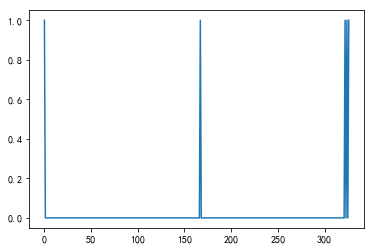

In [122]:
a=list(lift_time_series_dict.keys())
plt.plot(lift_time_series_dict[a[0]])

# 尝试训练LSTM模型

In [5]:
n_feats = 32
latent_dim = 64
lstm_input = keras.layers.Input(shape=(None, n_feats))
lstm_output = keras.layers.LSTM(latent_dim)(lstm_input)
model = keras.models.Model(lstm_input, lstm_output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
Total params: 24,832
Trainable params: 24,832
Non-trainable params: 0
_________________________________________________________________


In [8]:
lift_time_series_data=np.array(list(lift_time_series_dict.values()))
train_size=int(len(lift_time_series_data)*0.67)
test_size=len(lift_time_series_data)-train_size
train,test=lift_time_series_data[0:train_size],lift_time_series_data[train_size:len(lift_time_series_data)]

In [57]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size),:]
        data_X.append(a)
        data_Y.append(dataset[i + window_size,:])
    return(np.array(data_X), np.array(data_Y))

In [9]:
# Look back即为滑动的时间窗口
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
#trainX=np.reshape(trainX, (trainX.shape[0], -1, trainX.shape[1]))
#testX=np.reshape(testX, (testX.shape[0], -1, testX.shape[1]))

In [201]:
print(np.shape(train))
aa=[]
aa.append(train[2:(2+1)][0])
aa.append(train[3:(3+1)][0])
np.shape(aa)
aa=np.array(aa)
aa[0]
trainX=trainX[:,None,None]
trainY=trainY[:,None,None]
b[0]
b[0]

(43878,)


array([[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.

(43878,)
(327,) (327,)


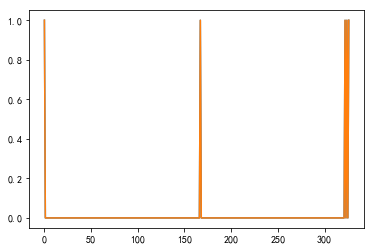

In [94]:
print(np.shape(train))
a=np.reshape(train, (train.shape[0],-1,1))
np.shape(a)
print(np.shape(train[0]),np.shape(a[0][0][0]))
plt.plot(a[0][0][0])
plt.plot(train[0])

In [207]:
# Second test to create and fit the LSTM network
n_feats = 1
latent_dim = 1
model = keras.models.Sequential()
model.add(keras.layers.LSTM(1, input_shape=(None,look_back)))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(train, trainY, epochs=100, batch_size=1, verbose=2)

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 

似乎对于变长的时间序列，可能需要padding或者bucketing层把序列都变换到相同的长度，不然会出现batch_input_shape的问题

In [10]:
train_pad=keras.preprocessing.sequence.pad_sequences(train,padding='post')
test_pad=keras.preprocessing.sequence.pad_sequences(test,padding='post')
train_pad.shape

(43878, 363)

Text(0.5, 1.0, '故障时间序列输入')

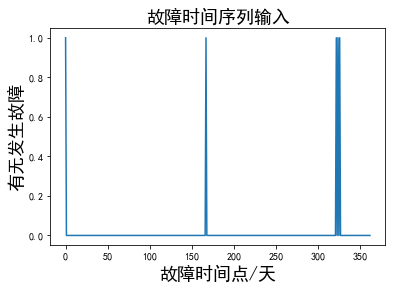

In [31]:
plt.plot(train_pad[0])
plt.xlabel('故障时间点/天',fontsize=18)
plt.ylabel('有无发生故障',fontsize=18)
plt.title('故障时间序列输入',fontsize=18)

In [16]:
# convert an array of values into a dataset matrix -->after padding<--
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size),:]
        data_X.append(a)
        data_Y.append(dataset[i + window_size,:])
    return(np.array(data_X), np.array(data_Y))

In [17]:
print(np.shape(train_pad),train_pad[1:3,:].shape)
trainX_pad, trainY_pad = create_dataset(train_pad, look_back)
testX_pad, testY_pad = create_dataset(test_pad, look_back)
print(trainX_pad[0].shape)

(43878, 363) (2, 363)
(1, 363)


In [18]:
# 产生one-step-ahead的训练和预测数据
look_back = 1
window_size = 1
trainX_pad, trainY_pad = create_dataset(train_pad, look_back)
testX_pad, testY_pad = create_dataset(test_pad, look_back)
print("Original training data shape:")
print(trainX_pad.shape)
trainX_pad = np.reshape(trainX_pad, (trainX_pad.shape[0], 1, trainX_pad.shape[2]))
testX_pad = np.reshape(testX_pad, (testX_pad.shape[0], 1, testX_pad.shape[2]))
print("New training data shape:")
print(trainX_pad.shape)

Original training data shape:
(43876, 1, 363)
New training data shape:
(43876, 1, 363)


In [69]:
train_pad.shape[1]

363

In [138]:
# 保存的该模型是input_shape=(1,1) Dense(1)的，按理来说输入应该是(1,) 每一个epoch训练要700s左右
#joblib.dump(model,'model_lstm_20epoch_20190114.asv')
# 保存的该模型是input_shape=(1,363) Dense(363)的，按理来说输入应该是(363,) 每一个epoch训练要300s左右
#joblib.dump(model,'model_lstm_3epoch_20190114.asv')
#joblib.dump(model,'model_lstm_100epoch_20190115.asv')
model=joblib.load('model_lstm_100epoch_20190115.asv')

['model_lstm_100epoch_20190115.asv']

In [19]:
# 模型评估
def predict_and_score(model, X, Y):
    pred=model.predict(X)
    score=np.sqrt(mean_squared_error(Y,pred))
    return (score,pred)

rmse_train, train_predict = predict_and_score(model, trainX_pad, trainY_pad)
rmse_test, test_predict = predict_and_score(model, testX_pad, testY_pad)

print("Training data score: %.8f RMSE" % rmse_train)
print("Test data score: %.8f RMSE" % rmse_test)

Training data score: 0.10460488 RMSE
Test data score: 0.10990360 RMSE


可视化预测结果，画出window_size下的预测图

In [97]:
[lift_time_series_data.shape[0],train_pad[1]]

[65491,
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0

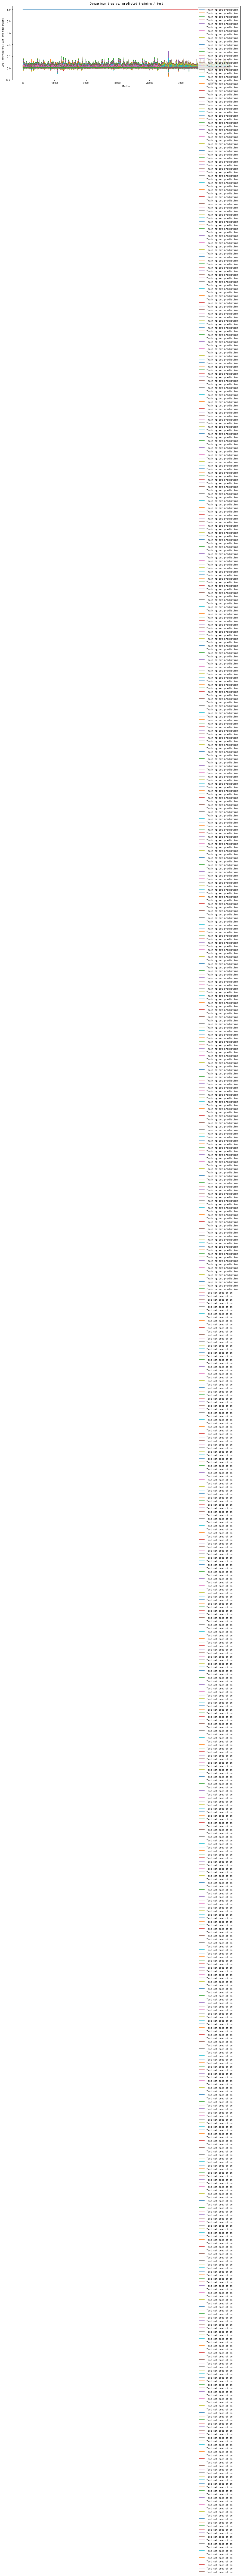

In [100]:
# Start with training predictions.
window_size=look_back
train_predict_plot = np.empty([lift_time_series_data.shape[0],train_pad.shape[1]])
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty([lift_time_series_data.shape[0],train_pad.shape[1]])
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(lift_time_series_data) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
#plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

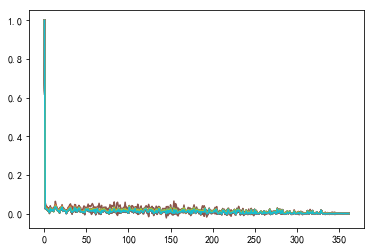

In [141]:
for i in range(50):
    plt.plot(train_predict[i])

In [20]:
window_size=1
train_predict_plot = np.empty([lift_time_series_data.shape[0],train_pad.shape[1]])
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty([lift_time_series_data.shape[0],train_pad.shape[1]])
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(lift_time_series_data) - 1, :] = test_predict

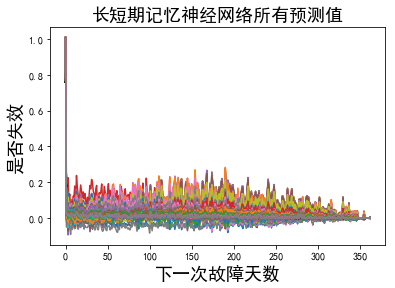

In [45]:
for i in range(int(0.5*len(train_predict))):
    plt.plot(train_predict[i])
plt.xlabel('下一次故障天数',fontsize=18)
plt.ylabel('是否失效',fontsize=18)
plt.title('长短期记忆神经网络所有预测值',fontsize=18)
plt.savefig('LSTM_train_predict.png')

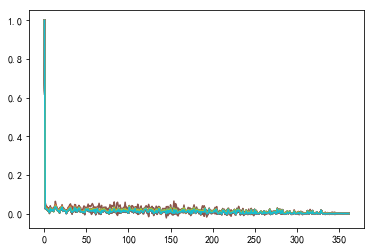

In [21]:
for i in range(50):
    plt.plot(train_predict[i])

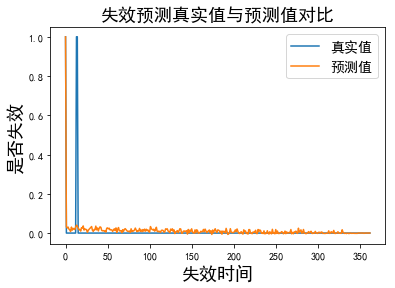

In [30]:
test_num=1000
plt.plot(trainY_pad[test_num],label="真实值")
plt.plot(train_predict[test_num], label = "预测值")
plt.xlabel("失效时间",fontsize=18)
plt.ylabel("是否失效",fontsize=18)
plt.title("失效预测真实值与预测值对比",fontsize=18)
plt.legend(fontsize=14)
plt.show()

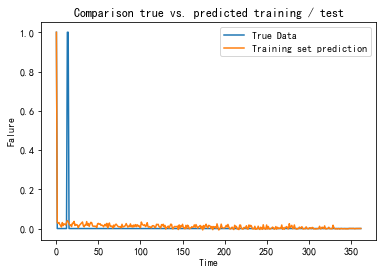

In [140]:
test_num=1000
plt.plot(trainY_pad[test_num],label="True Data")
plt.plot(train_predict[test_num], label = "Training set prediction")
plt.xlabel("Time")
plt.ylabel("Falure")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

该结果在100epoch和3个epoch下训练结果都不是很好，这和数据本身的稀疏性以及padding以后的结果有关，考虑
1. 找到不适合的原因（文献里面有说）
2. 采用SVR的方法来预测，因为文献中也有提到SVR会更有优势

更新于2019/2/11 不论是SVR还是LSTM，能够产生合适的特征辅助预测一直是一个关键，问题集中在
1. 特征从哪些方面构造？基本的时间序列统计特征？
2. 神经网络的模型结构如何修改呢？

# 尝试训练SVR模型

## 有必要考虑先估计出历史维修次数的分布

先分析历史维保的分布情况，组长有画了虹桥部分的直方图，我们画全国部分的，考虑使用威布尔分布拟合！？

In [153]:
#全国数据因为只有一年的，横坐标就是历史维修次数，纵坐标则是距离上一次维修的间隔？
print(lift_series_dict[30146560])
lift_intvl_series=np.mat(list(lift_series_dict.values()))
print(np.shape(lift_intvl_series))

[0, 167, 322, 324, 326]
(1, 115555)


In [191]:
%%time
# 由前面数据分析可知，电梯最多被维修过110次
history_repair=[]
max_len=np.max(pd.value_counts(lift['Equipment No'])) #最多维保次数
for repair_freq in range(1,max_len):
    repair_serires=[] #该维修次数下的时间间隔list
    for i in range(np.shape(lift_intvl_series)[1]):
        l=lift_intvl_series[0,i]
        try:
            repair_serires.append(np.abs(l[repair_freq]-l[repair_freq-1]))
        except IndexError as e:
            pass
    history_repair.append(repair_serires)#该次数下的间隔序列
    print(repair_freq/max_len*100,'%')

0.9090909090909091 %
1.8181818181818181 %
2.727272727272727 %
3.6363636363636362 %
4.545454545454546 %
5.454545454545454 %
6.363636363636363 %
7.2727272727272725 %
8.181818181818182 %
9.090909090909092 %
10.0 %
10.909090909090908 %
11.818181818181818 %
12.727272727272727 %
13.636363636363635 %
14.545454545454545 %
15.454545454545453 %
16.363636363636363 %
17.272727272727273 %
18.181818181818183 %
19.090909090909093 %
20.0 %
20.909090909090907 %
21.818181818181817 %
22.727272727272727 %
23.636363636363637 %
24.545454545454547 %
25.454545454545453 %
26.36363636363636 %
27.27272727272727 %
28.18181818181818 %
29.09090909090909 %
30.0 %
30.909090909090907 %
31.818181818181817 %
32.72727272727273 %
33.63636363636363 %
34.54545454545455 %
35.45454545454545 %
36.36363636363637 %
37.27272727272727 %
38.18181818181819 %
39.09090909090909 %
40.0 %
40.909090909090914 %
41.81818181818181 %
42.72727272727273 %
43.63636363636363 %
44.54545454545455 %
45.45454545454545 %
46.36363636363636 %
47.272727

In [194]:
joblib.dump(history_repair,'history_repair.asv')

['history_repair.asv']

Text(0.5,1,'全国数据历史维修次数与维修间隔分析')

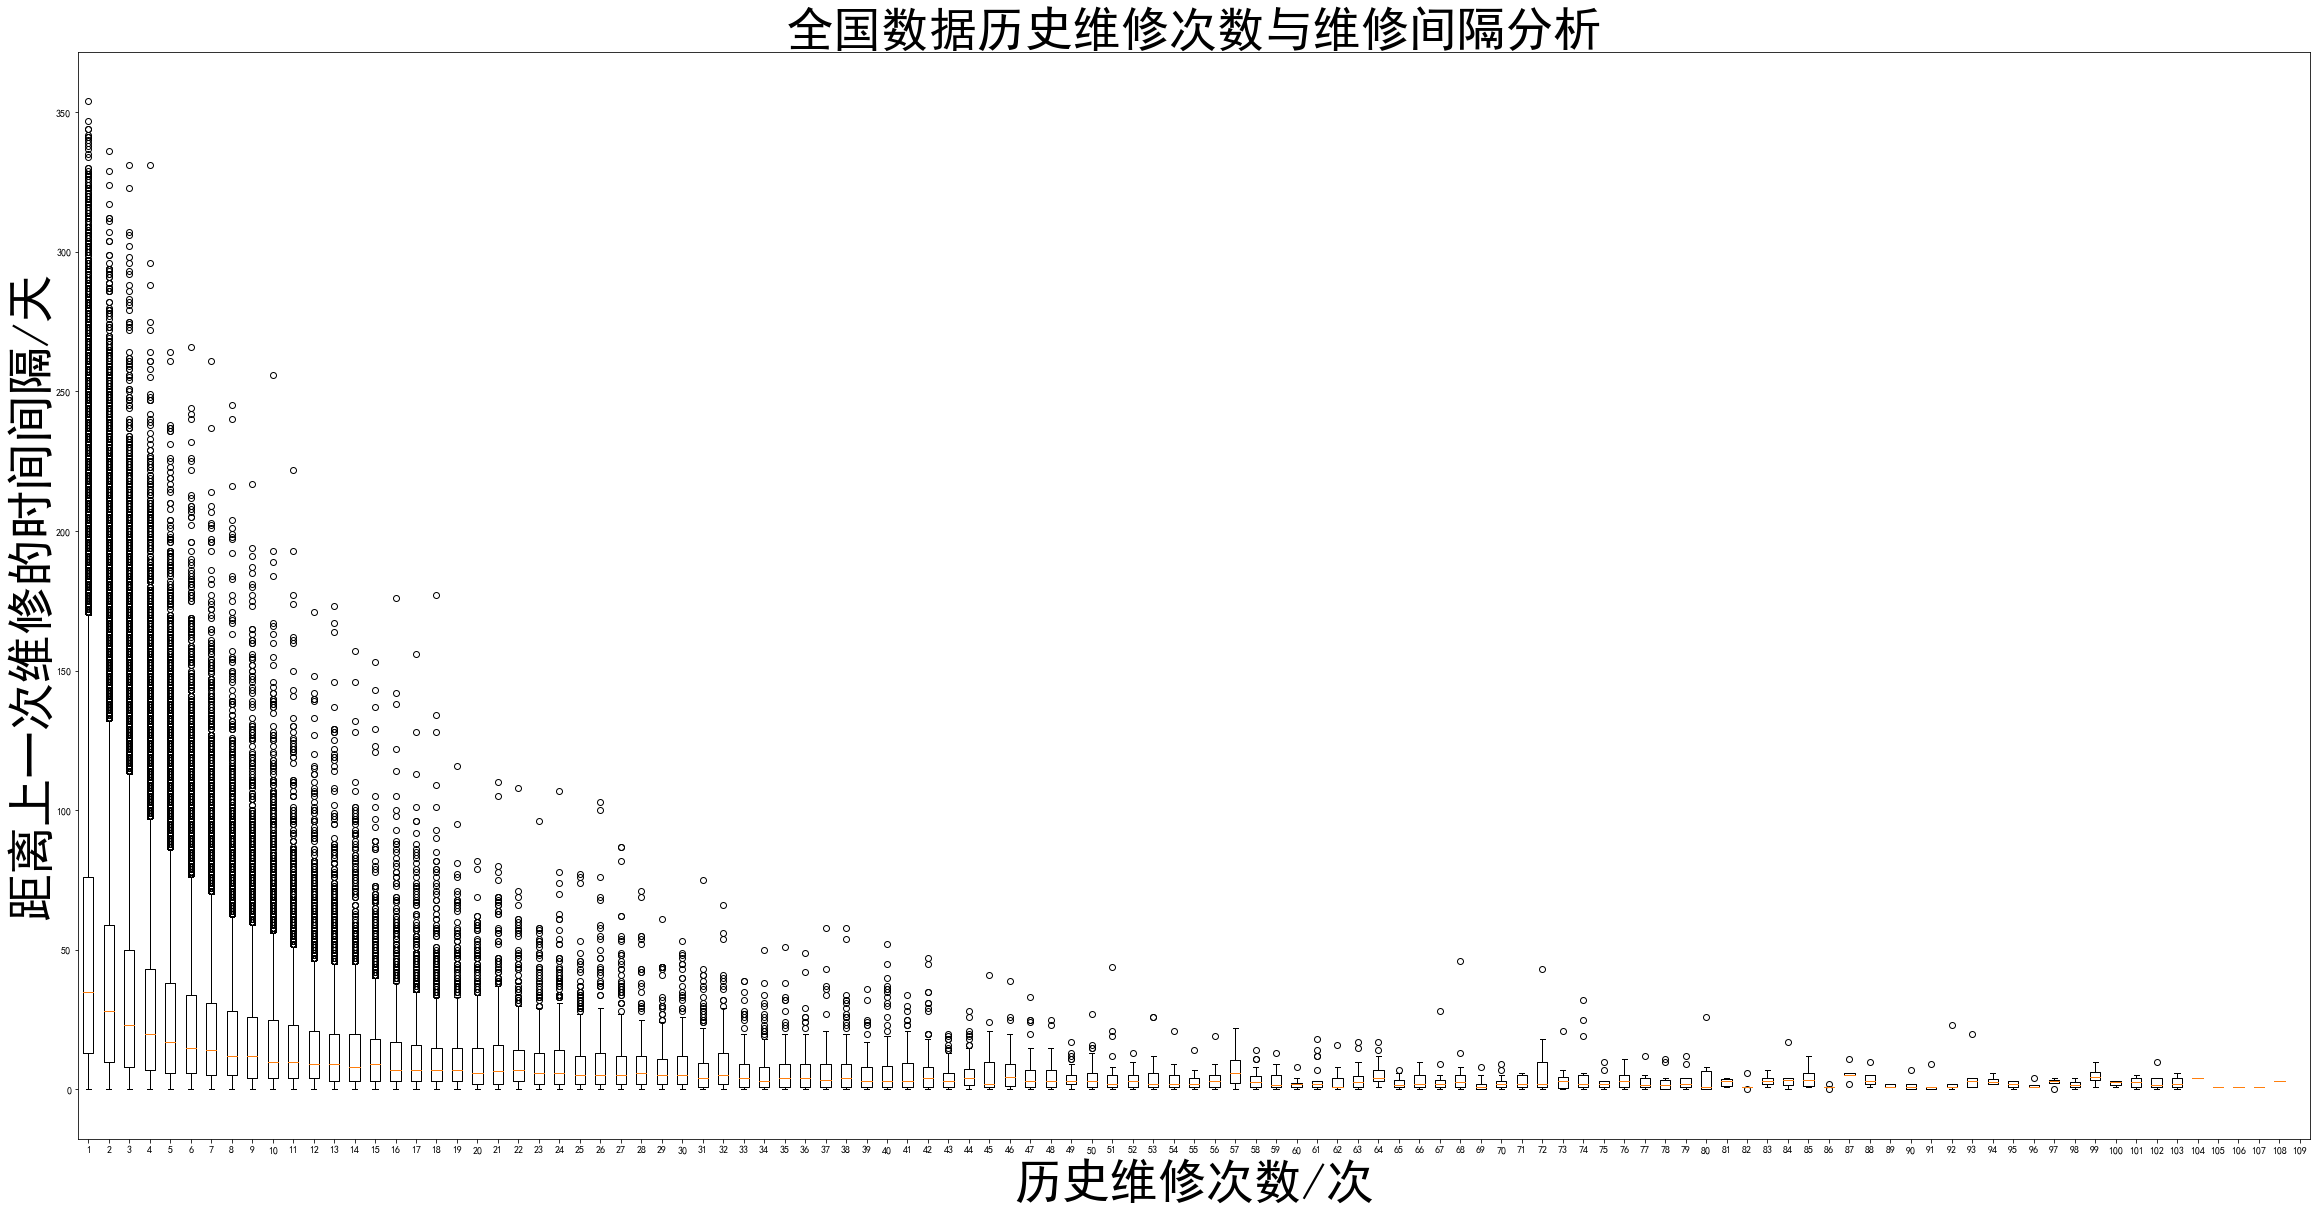

In [196]:
plt.figure(figsize=(40,20))
plt.boxplot(history_repair)
plt.xlabel('历史维修次数/次',fontsize=48)
plt.ylabel('距离上一次维修的时间间隔/天',fontsize=48)
plt.title('全国数据历史维修次数与维修间隔分析',fontsize=48)

## 如何构建分布并且拟合？考虑威布尔然后结合支持向量进行回归？
威布尔分布的横坐标是失效时间，我们的是历史维修次数，考虑直接先用一个简单的指数模型或者多项式尝试一下？

In [3]:
history_repair=joblib.load('history_repair.asv')

In [4]:
history_repair_distr=[]
for i in range(len(history_repair)):
    hr=history_repair[i]
    for j in hr:
        history_repair_distr.append([i+1,j])
history_repair_distr=np.mat(history_repair_distr)

In [61]:
# 多项式拟合
#f=np.polyfit(np.array(history_repair_distr[:,0]),np.array(history_repair_distr[:,1]),3)
x=[e[0] for e in np.array(history_repair_distr[:,0])]
y=[e[0] for e in np.array(history_repair_distr[:,1])]
x=np.array(x)
y=np.array(y)
# 必须考虑交叉验证才行
ss=np.arange(len(x))
np.random.shuffle(ss)
train_size=ss[:int(len(ss)*0.8)]
test_size=ss[int(len(ss)*0.8):len(ss)]
x1,y1=x[train_size],y[train_size]
x1_test,y1_test=x[test_size],y[test_size]

f=np.polyfit(x1,y1,5)
p1=np.poly1d(f)
# 指数分布拟合
def f2(x, a, b, c):
    return a * np.exp(-b * x) + c
popt, pcov = curve_fit(f2, x1, y1)
# 双曲线拟合
def f3(x,a,b,c,d):
    return a*x/(b*x+c)+d
popt3, pcov3 = curve_fit(f3, x1, y1)
# 指数中嵌套指数（因为似乎下降的比指数还快）
def f4(x,a,b,c):
    return a*np.exp(-b*np.exp(-c*x))
popt4, pcov4 = curve_fit(f4, x1, y1)

C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp
C:\Software\Programming\Anaconda\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [59]:
# SVR
clf=svm.SVR()
x2=np.reshape(x1,(-1,1))
clf.fit(x2,y1)
joblib.dump(clf,'svr_distr_0.8_rand.asv')

['svr_distr_0.8_rand.asv']

In [28]:
clf.score(np.reshape(x1_test,(-1,1)),y1_test)

-0.06238812882147493

In [6]:
clf=joblib.load('svr_distr.asv')

C:\Software\Programming\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Software\Programming\Anaconda\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


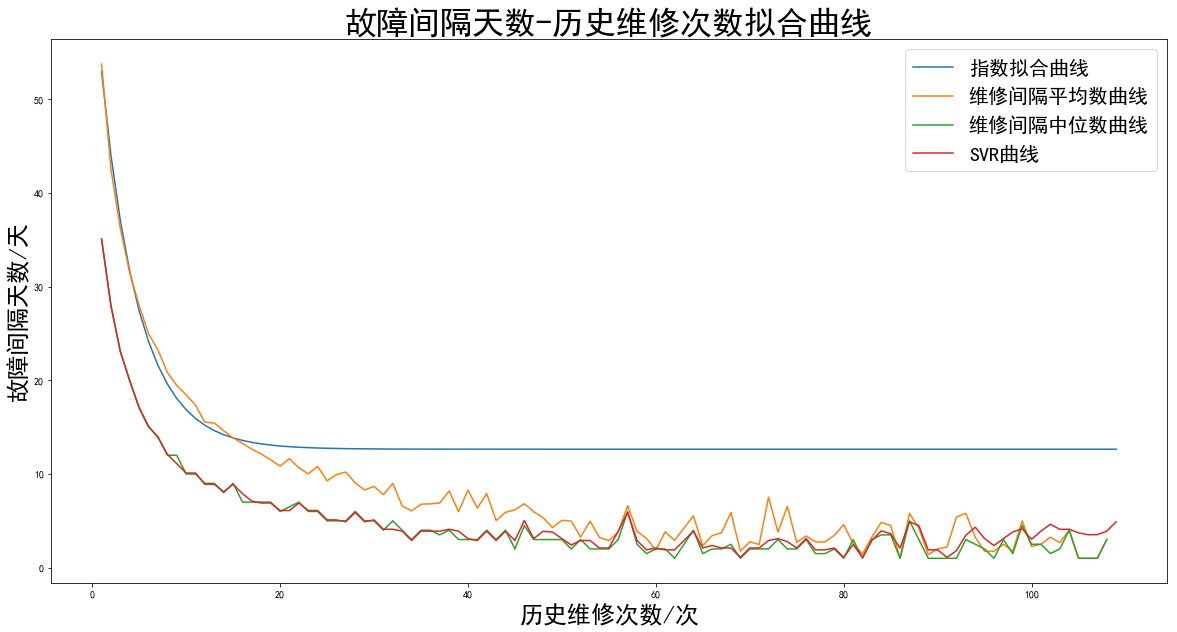

In [63]:
# 画出曲线图
xx=list(range(1,len(history_repair)+1))
yy_mean=[np.mean(e) for e in history_repair]
yy_median=[np.median(e) for e in history_repair]
y2=[f2(e,popt[0],popt[1],popt[2]) for e in xx]
y3=[f3(e,popt3[0],popt3[1],popt3[2],popt3[3]) for e in xx]
y4=[f4(e,popt4[0],popt4[1],popt4[2]) for e in xx]
y_svr=clf.predict(np.reshape(xx,(-1,1)))
plt.figure(figsize=(20,10))
#plt.plot(xx,p1(xx),label='多项式拟合曲线')
plt.plot(xx,y2,label='指数拟合曲线')
#plt.plot(xx,y3,label='双曲线拟合曲线')
#plt.plot(xx,y4,label='指数嵌套指数曲线')
plt.plot(xx,yy_mean,label='维修间隔平均数曲线')
plt.plot(xx,yy_median,label='维修间隔中位数曲线')
plt.plot(xx,y_svr,label='SVR曲线')
plt.xlabel('历史维修次数/次',fontsize=24)
plt.ylabel('故障间隔天数/天',fontsize=24)
plt.title('故障间隔天数-历史维修次数拟合曲线',fontsize=32)
plt.legend(fontsize=20)
plt.savefig('故障间隔天数-历史维修次数拟合曲线4.png')

使用SVR直接拟合出来的效果自然会好一点，但是否会存在过拟合的情况，要如何应对？我们又应该如何预测下一次故障呢？

对于过拟合的情况，我们并没有使用全部的数据进行拟合，我们只用了其中80%的数据，并且把这些数据都shuffle了一遍

下一步考虑构造变量然后再次输入到LSTM中

# 循环预测？

我们最后可以不让问题变成预测时间点的，我们可以预测下一次的时间间隔，这样的话，和上面的曲线预测有点像，但是可以
1. 一个生命周期内生成有重复计算区间的时间序列，然后用tsfresh?
2. 引入其他多变量因素诸如历史维修次数、上下次历史的维修间隔
3. 构造出有监督的预测

In [26]:
# 构造有监督的预测
lift_keys=list(lift_series_dict.keys())
lift_keys=np.array(lift_keys)
lift_recur_train_table=pd.DataFrame(columns=['liftNum','time','repairFrequency','lastRepairInt','nextRepairInt'])# next即为预测的supervised
for lift_key in tqdm_notebook(lift_keys):
    series=lift_series_dict[lift_key]
    if len(series)>2: # 必须长度大于三个才能做预测的
        for i in range(len(series)-1):            
            ln=lift_key
            t=series[i] # 从0开始计算，这样也可以大致估算出第二次容易出事故的时间
            rf= 0 if i==0 else i
            lf= 0 if i==0 else series[i-1]
            nr=series[i+1]
            lift_recur_train_table=lift_recur_train_table.append(pd.DataFrame({'liftNum':[ln],'time':[t],'repairFrequency':[rf],'lastRepairInt':[lf],'nextRepairInt':[nr]}),ignore_index=True)

A Jupyter Widget

In [74]:
lift_recur_train_table

,lastRepairInt,liftNum,nextRepairInt,repairFrequency,time
0,0,30146560,167,0,0
1,0,30146560,322,1,167
2,167,30146560,324,2,322
3,322,30146560,326,3,324
4,0,30146561,76,0,0
5,0,30146561,102,1,76
6,76,30146561,114,2,102
7,102,30146561,118,3,114
8,0,30146563,69,0,0
9,0,30146563,241,1,69


In [28]:
#np.where(lift_recur_train_table==np.nan)
lift_recur_train_table['liftNum']=pd.to_numeric(lift_recur_train_table['liftNum'])
lift_recur_train_table['time']=pd.to_numeric(lift_recur_train_table['time'])
lift_recur_train_table['repairFrequency']=pd.to_numeric(lift_recur_train_table['repairFrequency'])
lift_recur_train_table['lastRepairInt']=pd.to_numeric(lift_recur_train_table['lastRepairInt'])
lift_recur_train_table['nextRepairInt']=pd.to_numeric(lift_recur_train_table['nextRepairInt'])
lift_recur_train_table.dtypes
joblib.dump(lift_recur_train_table,'lift_recur_train_table.asv')

['lift_recur_train_table.asv']

监督学习——预测时间间隔

In [111]:
rg=svm.SVR()
neigh=KNeighborsRegressor(n_neighbors=5)# 运行的快的话可以写循环比较最优的neighbor数目
x=lift_recur_train_table[['time','repairFrequency','lastRepairInt']]
y=lift_recur_train_table['nextRepairInt']
# 考虑交叉验证才行
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2) # 数据已经生成 通过前面导入
# 用相同的训练测试集对比？
joblib.dump(x_train,'x_train_notsfresh_intervalPredict_0220.asv')
joblib.dump(y_train,'y_train_notsfresh_intervalPredict_0220.asv')
joblib.dump(x_test,'x_test_notsfresh_intervalPredict_0220.asv')
joblib.dump(y_test,'y_test_notsfresh_intervalPredict_0220.asv')

['y_test_notsfresh_intervalPredict_0220.asv']

In [27]:
%%time
# K-NN 预测
neigh.fit(x_train,y_train)

Wall time: 4.95 s


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [32]:
# n=5时的knn准确率，对不同情况如何？
rmse_train, train_predict, R_train = predict_and_score(neigh, x_train, y_train)
rmse_test, test_predict,R_test = predict_and_score(neigh, x_test, y_test)

print("Training data score: %.4f RMSE" % rmse_train)
print("Test data score: %.4f RMSE" % rmse_test)
print('Training data R squre value %.4f' % R_train)
print('Test data R squre value %.4f' % R_test)

a=neigh.predict(x_test)
a.astype(float).round()
print('Mean absolute error',mean_absolute_error(neigh.predict(x_test),y_test))
print('R2 before round',r2_score(neigh.predict(x_test),y_test))
print('Mean absolute error after round',mean_absolute_error(a,y_test))
print('Mean square error after round',mean_squared_error(a,y_test))
print('R2 after round',r2_score(a,y_test))
print('Model score',neigh.score(x_test,y_test))

Training data score: 37.3270 RMSE
Test data score: 40.4839 RMSE
Training data R squre value 0.8044
Test data R squre value 0.7704
Mean absolute error 27.495369007976457
R2 before round 0.7432763409722374
Mean absolute error after round 27.495369007976457
Mean square error after round 1638.949025013552
R2 after round 0.7432763409722374
Model score 0.7703720365326963


In [33]:
# 不同K情况下的预测准确率
knn_r2_train=[]
knn_r2_test=[]
for k in range(1,20):
    n=KNeighborsRegressor(n_neighbors=k)
    n.fit(x_train,y_train)
    s,p,r=predict_and_score(n,x_train,y_train)
    ss,pp,rr=predict_and_score(n,x_test,y_test)
    print('For K={:} train score {:} and R square value {:}'.format(k,s,r))
    print('For K={:} test score {:} and R square value {:}'.format(k,ss,rr))
    knn_r2_train.append(r)
    knn_r2_test.append(rr)
# 感觉K=10就差不多可以了

For K=1 train score 43.39078541184261 and R square value 0.7357968920131056
For K=1 test score 49.7997107448765 and R square value 0.6521346331729918
For K=2 train score 42.799299289817014 and R square value 0.7429508233309616
For K=2 test score 47.36127453564597 and R square value 0.6853669684977716
For K=3 train score 40.76126411002562 and R square value 0.7668485140049854
For K=3 test score 44.45054590025028 and R square value 0.722851999083308
For K=4 train score 38.34462715624889 and R square value 0.7936749599486741
For K=4 test score 41.517457483852354 and R square value 0.7582207357489875
For K=5 train score 38.59152711382145 and R square value 0.7910093635760831
For K=5 test score 41.25906072798062 and R square value 0.7612209465088705
For K=6 train score 42.159540268441944 and R square value 0.7505780717231815
For K=6 test score 44.3106027433092 and R square value 0.7245943359777646
For K=7 train score 42.45972535018087 and R square value 0.7470135500733027
For K=7 test score

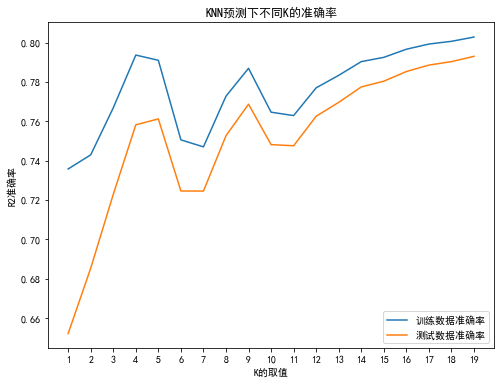

In [34]:
plt.figure(figsize=(8,6))
knn_x=list(range(1,20))
plt.plot(knn_x,knn_r2_train,label='训练数据准确率')
plt.plot(knn_x,knn_r2_test,label='测试数据准确率')
plt.title('KNN预测下不同K的准确率',fontsize=18)
plt.xlabel('K的取值',fontsize=18)
plt.ylabel('R2准确率',fontsize=18)
plt.xticks(list(range(1,20)))
plt.legend()

In [37]:
lift_recur_train_table.head(10)

,lastRepairInt,liftNum,nextRepairInt,repairFrequency,time
0,0,30146560,167,0,0
1,0,30146560,322,1,167
2,167,30146560,324,2,322
3,322,30146560,326,3,324
4,0,30146561,76,0,0
5,0,30146561,102,1,76
6,76,30146561,114,2,102
7,102,30146561,118,3,114
8,0,30146563,69,0,0
9,0,30146563,241,1,69


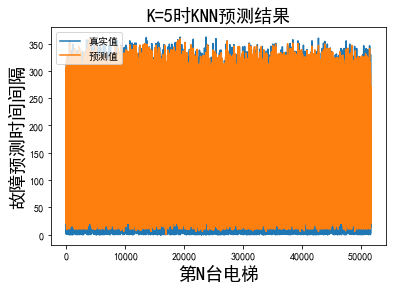

In [31]:
plt.plot(list(range(len(y_test))),y_test)
plt.plot(list(range(len(y_test))),neigh.predict(x_test))
plt.xlabel('第N台电梯',fontsize=18)
plt.ylabel('故障预测时间间隔',fontsize=18)
plt.title('K=5时KNN预测结果',fontsize=18)
plt.legend(['真实值','预测值'])
plt.savefig('KNN=5.png')

In [29]:
print(neigh.predict(x_test)[:20],'\n',y_test[:20])

[ 59.8  34.4 205.  125.   34.4 106.8 219.  268.8 171.4 148.4  34.4  49.
 164.4  72.8  46.4 141.4 304.  107.4 162.4  36.2] 
 21296      45
224605    113
88021     192
119953    121
28872      31
55291      81
224119    205
29752     256
53183      52
184307    140
232401     20
238507     88
180647    142
54835      59
10399      26
195219    123
194376    325
190108     63
64966     114
93798      20
Name: nextRepairInt, dtype: int64


In [4]:
%%time
rg.fit(x_train,y_train)
joblib.dump(rg,'rg_e1_0213.asv')

Wall time: 3h 12min 20s


In [5]:
rg.score(x_test,y_test) # R square value of SVR

0.7091882819389081

## 如果把时间点预测给纠正过来的话？

In [4]:
# 此前的构造是基于时间点的，这一次lastrepairInt和nextRepairInt应该是时间间隔而不是时间点
lift_keys=list(lift_series_dict.keys())
lift_keys=np.array(lift_keys)
lift_recur_train_table_correct=pd.DataFrame(columns=['liftNum','time','repairFrequency','lastRepairInt','nextRepairInt'])# next即为预测的supervised
for lift_key in tqdm_notebook(lift_keys):
    series=lift_series_dict[lift_key]
    if len(series)>2: # 必须长度大于三个才能做预测的
        for i in range(len(series)-1):            
            ln=lift_key
            t=series[i] # 从0开始计算，这样也可以大致估算出第二次容易出事故的时间
            rf= 0 if i==0 else i
            lf= 0 if i==0 else series[i]-series[i-1]
            nr=series[i+1]-series[i]
            lift_recur_train_table_correct=lift_recur_train_table_correct.append(pd.DataFrame({'liftNum':[ln],'time':[t],'repairFrequency':[rf],'lastRepairInt':[lf],'nextRepairInt':[nr]}),ignore_index=True)
joblib.dump(lift_recur_train_table_correct,'lift_recur_train_table_correct.asv')

A Jupyter Widget

['lift_recur_train_table_correct.asv']

In [18]:
lift_recur_train_table_correct.head(20)

,lastRepairInt,liftNum,nextRepairInt,repairFrequency,time
0,0,30146560,167,0,0
1,167,30146560,155,1,167
2,155,30146560,2,2,322
3,2,30146560,2,3,324
4,0,30146561,76,0,0
5,76,30146561,26,1,76
6,26,30146561,12,2,102
7,12,30146561,4,3,114
8,0,30146563,69,0,0
9,69,30146563,172,1,69


In [16]:
neigh_correct=KNeighborsRegressor(n_neighbors=5)# 运行的快的话可以写循环比较最优的neighbor数目
xx=lift_recur_train_table_correct[['time','repairFrequency','lastRepairInt']]
yy=lift_recur_train_table_correct['nextRepairInt']
# 考虑交叉验证才行
xx_train, xx_test, yy_train, yy_test = train_test_split(xx, yy, test_size = 0.2) # 数据已经生成 通过前面导入

In [13]:
lift_recur_train_table_correct.head(10)

,lastRepairInt,liftNum,nextRepairInt,repairFrequency,time
0,0,30146560,167,0,0
1,167,30146560,155,1,167
2,155,30146560,2,2,322
3,2,30146560,2,3,324
4,0,30146561,76,0,0
5,76,30146561,26,1,76
6,26,30146561,12,2,102
7,12,30146561,4,3,114
8,0,30146563,69,0,0
9,69,30146563,172,1,69


In [159]:
neigh_correct.fit(xx_train,yy_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

提前预测百分比: 0.3340044915976148  延迟预测百分比 0.653024084256176
以下预测均不包含前面的区间
准确预测比例: 0.012971424146209247
提前预测一天比例: 0.012177650429799427 延迟预测一天比例: 0.01543018663362503
提前预测五天比例: 0.043986680089831955 延迟预测五天比例: 0.061856268876326184
提前预测十天比例: 0.04189576395880121 延迟预测十天比例: 0.07910632695732982
提前预测半个月比例: 0.0332610547510261 延迟预测半个月比例: 0.0738403159606598
提前预测一个月比例: 0.07176876016417563 延迟预测一个月比例: 0.1538952993107721
Mean absolute error 34.59158599860606
Mean absolute error after round 34.5362425462712
Mean square error after round 2296.8623093007045
R2 after round -0.8644870577606831
R2 before round -0.8579300632407412


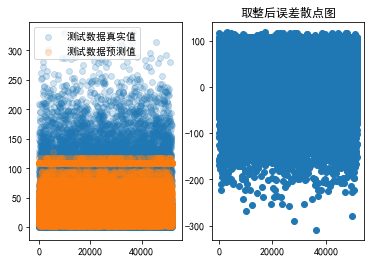

In [168]:
printModelDeviation(neigh_correct.predict(xx_test),yy_test)

In [ ]:
# 不同K情况下的预测准确率
knn_r2_train=[]
knn_r2_test=[]
for k in range(1,20):
    n=KNeighborsRegressor(n_neighbors=k)
    n.fit(x_train,y_train)
    s,p,r=predict_and_score(n,xx_train,yy_train)
    ss,pp,rr=predict_and_score(n,xx_test,yy_test)
    print('For K={:} train score {:} and R square value {:}'.format(k,s,r))
    print('For K={:} test score {:} and R square value {:}'.format(k,ss,rr))
    knn_r2_train.append(r)
    knn_r2_test.append(rr)
# 感觉K=10就差不多可以了

In [ ]:
plt.figure(figsize=(8,6))
knn_x=list(range(1,20))
plt.plot(knn_x,knn_r2_train,label='训练数据准确率')
plt.plot(knn_x,knn_r2_test,label='测试数据准确率')
plt.title('KNN预测下不同K的准确率')
plt.xlabel('K的取值')
plt.ylabel('R2准确率')
plt.xticks(list(range(1,20)))
plt.legend()

In [39]:
print(np.round(neigh_correct.predict(xx_test[:20])))
print(list(yy_test[:20]))
print(r2_score(np.round(neigh_correct.predict(xx_test[:20])),yy_test[:20]))
print(mean_absolute_error(np.round(neigh_correct.predict(xx_test[:20])),yy_test[:20]))

[225.  70.  70.  52. 294. 216. 149. 284. 107. 312.  70.  62. 125. 293.
 172. 152.  70. 195. 176.  27.]
[299, 81, 24, 62, 288, 201, 136, 304, 165, 302, 54, 126, 178, 292, 150, 121, 13, 237, 164, 2]
0.8327008153751587
29.3


如果是这样构造下一次故障间隔的话，最终得到的效果并不是非常理想，考虑要有更理想的表示方式并且解释一下为什么之前的会那么好

不考虑构造时间序列构造的特征，单纯构造间隔特征的话，似乎knn的预测效果比SVR更好,不过还未使用tsfresh添加特征,下一步开始添加时序特征

In [33]:
# ts_features=tsf.extract_features(lift_recur_train_table,column_id='liftNum',column_sort='time')

变量过大导致内存溢出,考虑我们自己选取并计算特征？

In [5]:
from tsf.feature_extraction.settings import MinimalFCParameters
ts_features=tsf.extract_features(lift_recur_train_table,column_id='liftNum',column_sort='time',default_fc_parameters=MinimalFCParameters())

Feature Extraction: 100%|█████████████████| 20/20 [00:14<00:00,  2.03it/s]


## 评估并解释基于时间点的回归模型
既然下一次间隔的预测模型效果不好，那我们考虑解释一下预测时间点的合理性，比如预测范围在xx天以内的分布如何

In [157]:
# 先针对KNN拟合模型并生成预测变量
n=KNeighborsRegressor(n_neighbors=10)
n.fit(x_train,y_train)
knn_pred=n.predict(x_test)

In [70]:
knn_pred_rd=knn_pred.round()# round the results
knn_dt=knn_pred_rd-y_test #负数代表提前预测，正数代表预测滞后
knn_dt_abs=np.absolute(knn_dt)

提前预测百分比: 0.3715441802834353  延迟预测百分比 0.6154456749012623
以下预测均不包含前面的区间
准确预测比例: 0.013010144815302408
提前预测一天比例: 0.012758460466196856 延迟预测一天比例: 0.014481530240842562
提前预测五天比例: 0.04232169131882599 延迟预测五天比例: 0.06561217377836288
提前预测十天比例: 0.04570974986447766 延迟预测十天比例: 0.08983195229613568
提前预测半个月比例: 0.03744288701308759 延迟预测半个月比例: 0.0860373267250058
提前预测一个月比例: 0.07573762874622474 延迟预测一个月比例: 0.2067683729574847
Mean absolute error 26.947705800356225
Mean absolute error after round 26.954832339502826
Mean square error after round 1521.1379423836445
R2 after round 0.7475826701949698
R2 before round 0.7478460592570344


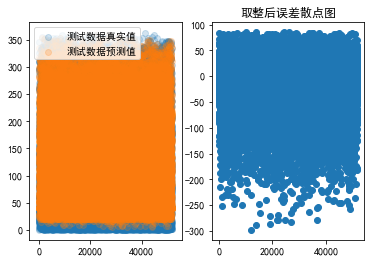

In [167]:
printModelDeviation(knn_pred,y_test)

[0.01343033 0.02807479 0.02798785 0.02608522 0.02007355 0.00822408
 0.00140199]
[0.01343033 0.11229914 0.13993924 0.13042609 0.30110321 0.24672236
 0.05607962]


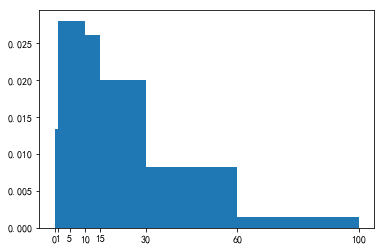

In [94]:
h=plt.hist(knn_dt_abs,bins=[0,1,5,10,15,30,60,100],stacked=True,density=True,histtype='barstacked',rwidth=1)
plt.xticks([0,1,5,10,15,30,60,100])
plt.xlabel('')
print(h[0])
print(h[0]*[1,4,5,5,15,30,40])
#plt.plot(np.zeros(10),np.linspace(0,16000,10))

Text(0,0.5,'所占比例')

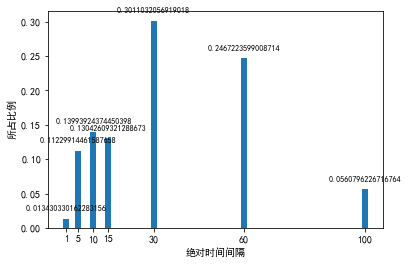

In [136]:
plt.bar([1,5,10,15,30,60,100],h[0]*[1,4,5,5,15,30,40],width=2)
plt.xticks([1,5,10,15,30,60,100])
for a,b in zip([1,5,10,15,30,60,100],h[0]*[1,4,5,5,15,30,40]):
    plt.text(a, b+0.01, b, ha='center', va= 'bottom',fontsize=8)
plt.xlabel('绝对时间间隔')
plt.ylabel('所占比例')

可以看出延迟的预测还是十分严重的，但是这也是回归问题不可避免的，而且很大一部分会集中在一个月的程度,原因应该还是有许多数据波动太大，是否考虑重新筛选！？

## 重新筛选训练数据

In [144]:
lift_less_10=lift_recur_train_table_correct[lift_recur_train_table['repairFrequency']<10]
x_less_10=lift_less_10[['time','repairFrequency','lastRepairInt']]
y_less_10=lift_less_10['nextRepairInt']
# 考虑交叉验证才行
x_train_less_10, x_test_less_10, y_train_less_10, y_test_less_10 = train_test_split(x_less_10, y_less_10, test_size = 0.2) # 数据已经生成 通过前面导入

提前预测百分比: 0.3386673035586339  延迟预测百分比 0.6510845256964196
以下预测均不包含前面的区间
准确预测比例: 0.010248170744946479
提前预测一天比例: 0.009357969472610026 延迟预测一天比例: 0.010291595197255575
提前预测五天比例: 0.035803460928849035 延迟预测五天比例: 0.04728922856460473
提前预测十天比例: 0.038278654710467465 延迟预测十天比例: 0.06965282150378878
提前预测半个月比例: 0.03187354799487591 延迟预测半个月比例: 0.07809887747790781
提前预测一个月比例: 0.07054302277612523 延迟预测一个月比例: 0.22200751243024947
Mean absolute error 29.72992017138184
Mean absolute error after round 29.71014178083679
Mean square error after round 1605.9871897865687
R2 after round -5.640044398156276
R2 before round -5.598903238319809


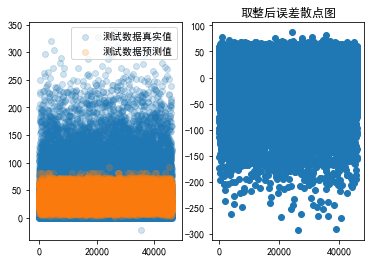

In [166]:
# KNN 回归
n_less_10=KNeighborsRegressor(n_neighbors=15)
n_less_10.fit(x_train_less_10,y_train_less_10)
printModelDeviation(n_less_10.predict(x_test_less_10),y_test_less_10)

In [33]:
lift_larger_10=lift_recur_train_table_correct[lift_recur_train_table['repairFrequency']>=10]
x_larger_10=lift_larger_10[['time','repairFrequency','lastRepairInt']]
y_larger_10=lift_larger_10['nextRepairInt']
# 考虑交叉验证才行
x_train_larger_10, x_test_larger_10, y_train_larger_10, y_test_larger_10 = train_test_split(x_larger_10, y_larger_10, test_size = 0.2) # 数据已经生成 通过前面导入

In [38]:
len(lift_larger_10)

27973

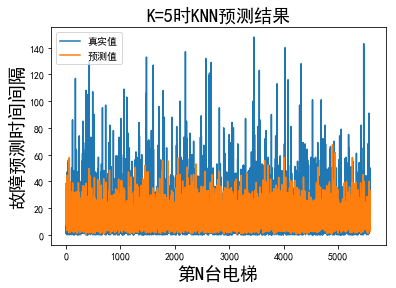

In [37]:
n_larger_10=KNeighborsRegressor(n_neighbors=5)
n_larger_10.fit(x_train_larger_10,y_train_larger_10)

plt.plot(list(range(len(y_test_larger_10))),y_test_larger_10)
plt.plot(list(range(len(y_test_larger_10))),n_larger_10.predict(x_test_larger_10))
plt.xlabel('第N台电梯',fontsize=18)
plt.ylabel('故障预测时间间隔',fontsize=18)
plt.title('K=5时KNN预测结果',fontsize=18)
plt.legend(['真实值','预测值'])
plt.savefig('KNN=5 larger 10.png')

In [43]:
# 模型评估
def predict_and_score(model, X, Y):
    pred=model.predict(X)
    score=np.sqrt(mean_squared_error(Y,pred))
    R=model.score(X,Y)
    return (score,pred,R)
# 不同K情况下的预测准确率
knn_r2_train=[]
knn_r2_test=[]
for k in range(1,20):
    n=KNeighborsRegressor(n_neighbors=k)
    n.fit(x_train_larger_10,y_train_larger_10)
    s,p,r=predict_and_score(n,x_train_larger_10,y_train_larger_10)
    ss,pp,rr=predict_and_score(n,x_test_larger_10,y_test_larger_10)
    print('For K={:} train score {:} and R square value {:}'.format(k,s,r))
    print('For K={:} test score {:} and R square value {:}'.format(k,ss,rr))
    knn_r2_train.append(r)
    knn_r2_test.append(rr)
# 感觉K=10就差不多可以了

For K=1 train score 8.280936654614445 and R square value 0.7574242423254
For K=1 test score 22.72366145653168 and R square value -0.8426050959062096
For K=2 train score 11.591379323741661 and R square value 0.5247099660591319
For K=2 test score 19.646168563652726 and R square value -0.3773089797950637
For K=3 train score 13.172487949667037 and R square value 0.3862039469093403
For K=3 test score 18.467508575920252 and R square value -0.21700472907313453
For K=4 train score 13.975157863631912 and R square value 0.30912112045699114
For K=4 test score 17.88948829149526 and R square value -0.14201414620058994
For K=5 train score 14.420777814743447 and R square value 0.2643591411671474
For K=5 test score 17.533821472866638 and R square value -0.09705602702168714
For K=6 train score 14.676842743331534 and R square value 0.23800213682751736
For K=6 test score 17.314604435562597 and R square value -0.06979557097111533
For K=7 train score 14.905219153363024 and R square value 0.2141037737571589

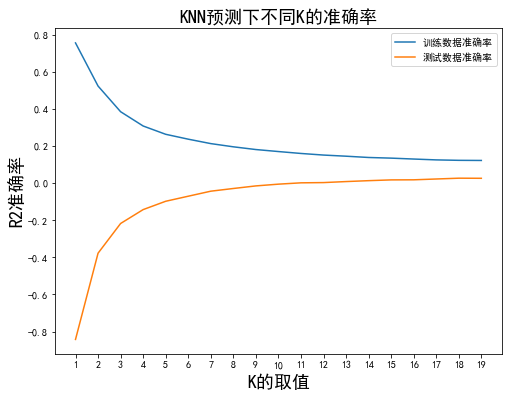

In [44]:
plt.figure(figsize=(8,6))
knn_x=list(range(1,20))
plt.plot(knn_x,knn_r2_train,label='训练数据准确率')
plt.plot(knn_x,knn_r2_test,label='测试数据准确率')
plt.title('KNN预测下不同K的准确率',fontsize=18)
plt.xlabel('K的取值',fontsize=18)
plt.ylabel('R2准确率',fontsize=18)
plt.xticks(list(range(1,20)))
plt.legend()

提前预测百分比: 0.33923145665773013  延迟预测百分比 0.6318141197497766
以下预测均不包含前面的区间
准确预测比例: 0.028954423592493297
提前预测一天比例: 0.026630920464700624 延迟预测一天比例: 0.03485254691689008
提前预测五天比例: 0.08168007149240393 延迟预测五天比例: 0.1840929401251117
提前预测十天比例: 0.06577301161751564 延迟预测十天比例: 0.19714030384271672
提前预测半个月比例: 0.04807864164432529 延迟预测半个月比例: 0.13065236818588025
提前预测一个月比例: 0.06934763181411975 延迟预测一个月比例: 0.0840035746201966
Mean absolute error 11.131867739052725
Mean absolute error after round 11.13065236818588
Mean square error after round 291.29794459338694
R2 after round -6.408464810862263
R2 before round -6.415575602979861


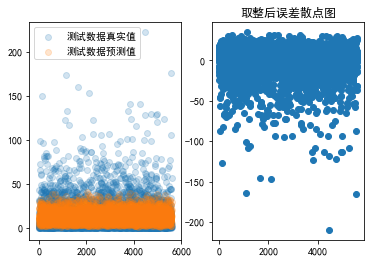

In [170]:
n_larger_10=KNeighborsRegressor(n_neighbors=15)
n_larger_10.fit(x_train_larger_10,y_train_larger_10)
printModelDeviation(n_larger_10.predict(x_test_larger_10),y_test_larger_10)

# 尝试预测具体部件的损坏？

In [4]:
tsf.utilities.dataframe_functions.roll_time_series(lift_recur_train_table,column_id='liftNum',column_sort='time',max_timeshift=15,column_kind=None,rolling_direction=1)

C:\Software\Programming\Anaconda\lib\site-packages\tsfresh\utilities\dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


,lastRepairInt,nextRepairInt,repairFrequency,time,liftNum
966517,0.0,23.0,1.0,-22.0,-22
757919,0.0,23.0,1.0,-22.0,0
191417,0.0,0.0,0.0,0.0,0
240549,0.0,0.0,0.0,0.0,0
240550,0.0,0.0,1.0,0.0,0
301317,0.0,7.0,5.0,0.0,0
301318,0.0,0.0,0.0,0.0,0
301319,0.0,0.0,1.0,0.0,0
301320,0.0,0.0,2.0,0.0,0
377369,0.0,7.0,5.0,0.0,0


先只考虑第一级的损坏部件，运用同样的预测算法再次测试，尝试将最终结果精细到部件上，承接之前的工作的话只需要在lift_recur_table的基础上加上对应的损坏部件即可！？

In [54]:
component_first=[]
for row in lift['Component Desc']:
    if not pd.isnull(row):
        component_first.append(row.split(' - ')[0])
    else:
        component_first.append('Not applicable')


In [57]:
components=np.unique(component_first)
components_dict={}
for i in range(len(components)):
    components_dict[i]=components[i]
components_dict_re=dict(zip(components_dict.values(),components_dict.keys()))
joblib.dump(components_dict,'components_dict.asv')
joblib.dump(components_dict_re,'component_dict_re.asv')

['component_dict_re.asv']

In [59]:
components_dict

{0: 'Not applicable',
 1: '井道设备',
 2: '信号装置',
 3: '周边装置',
 4: '对重',
 5: '导轨',
 6: '控制系统',
 7: '暂停待命',
 8: '机房设备',
 9: '轿厢',
 10: '轿厢架',
 11: '钢丝绳装置',
 12: '门及出入口',
 13: '驱动系统'}

是否每次维修的部件都相同？是否存在一定的部件先后顺序之类的意想不到的关联？

In [65]:
# 生成每个设备部件的时间序列dict，记录每次时间
lift['Component Desc']=pd.Series([components_dict_re[e] for e in component_first])
lift_unq=set(lift['Equipment No'])
lift_unq=list(lift_unq)
lift_comp_series_dict={}
for i in tqdm_notebook(range(len(lift_unq))):
    lf=lift_unq[i] #电梯设备编号
    lf_tp=list(lift[lift['Equipment No']==lf]['Receive time'])# 得到该电梯的走修时间点(time point)
    lf_comp=list(lift[lift['Equipment No']==lf]['Component Desc'])# 走修的描述编号，会比维修间隔编号多一位出来
    lf_ts=[0]# 电梯走修序列
    for j in range(1,len(lf_tp)-1):
        try:
            time_delta=lf_tp[j].date()-lf_tp[0].date()
            lf_ts.append(time_delta.days)
        except AttributeError as e:            
            print(lf,e,'Series No.',j)
    lift_comp_series_dict[lf]=[lf_ts,lf_comp]
joblib.dump(lift_comp_series_dict,'lift_comp_series_dict.asv')

A Jupyter Widget

30408826 'float' object has no attribute 'date' Series No. 5
30408832 'float' object has no attribute 'date' Series No. 2
30147035 'float' object has no attribute 'date' Series No. 1
30409497 'float' object has no attribute 'date' Series No. 41
30409497 'float' object has no attribute 'date' Series No. 42
30409497 'float' object has no attribute 'date' Series No. 43
30409497 'float' object has no attribute 'date' Series No. 44
30409497 'float' object has no attribute 'date' Series No. 45
30409497 'float' object has no attribute 'date' Series No. 46
30409497 'float' object has no attribute 'date' Series No. 47
30409500 'float' object has no attribute 'date' Series No. 11
30409501 'float' object has no attribute 'date' Series No. 15
30409502 'float' object has no attribute 'date' Series No. 22
30409502 'float' object has no attribute 'date' Series No. 23
30409503 'float' object has no attribute 'date' Series No. 32
30409503 'float' object has no attribute 'date' Series No. 33
30409504 'f

30160466 'float' object has no attribute 'date' Series No. 18
30160466 'float' object has no attribute 'date' Series No. 19
30160467 'float' object has no attribute 'date' Series No. 4
30160467 'float' object has no attribute 'date' Series No. 5
30160467 'float' object has no attribute 'date' Series No. 18
30160467 'float' object has no attribute 'date' Series No. 19
30160468 'float' object has no attribute 'date' Series No. 3
30160468 'float' object has no attribute 'date' Series No. 4
30160526 'float' object has no attribute 'date' Series No. 7
30422937 'float' object has no attribute 'date' Series No. 4
30161049 'float' object has no attribute 'date' Series No. 1
30161146 'float' object has no attribute 'date' Series No. 11
30162189 'float' object has no attribute 'date' Series No. 12
30162189 'float' object has no attribute 'date' Series No. 13
30162347 'float' object has no attribute 'date' Series No. 2
30162348 'float' object has no attribute 'date' Series No. 1
30162359 'float' 

30172394 'float' object has no attribute 'date' Series No. 24
30172394 'float' object has no attribute 'date' Series No. 25
30172395 'float' object has no attribute 'date' Series No. 7
30172395 'float' object has no attribute 'date' Series No. 8
30434637 'float' object has no attribute 'date' Series No. 15
30434637 'float' object has no attribute 'date' Series No. 16
30434642 'float' object has no attribute 'date' Series No. 8
30434771 'float' object has no attribute 'date' Series No. 2
30434771 'float' object has no attribute 'date' Series No. 3
30434772 'float' object has no attribute 'date' Series No. 1
30434782 'float' object has no attribute 'date' Series No. 15
30434782 'float' object has no attribute 'date' Series No. 16
30172868 'float' object has no attribute 'date' Series No. 3
30172873 'float' object has no attribute 'date' Series No. 2
30435462 'float' object has no attribute 'date' Series No. 1
30435462 'float' object has no attribute 'date' Series No. 2
30435463 'float' o

30186298 'float' object has no attribute 'date' Series No. 1
30186298 'float' object has no attribute 'date' Series No. 2
30186298 'float' object has no attribute 'date' Series No. 3
30186298 'float' object has no attribute 'date' Series No. 4
30175746 'float' object has no attribute 'date' Series No. 9
30175746 'float' object has no attribute 'date' Series No. 10
30175746 'float' object has no attribute 'date' Series No. 11
30175746 'float' object has no attribute 'date' Series No. 12
30175746 'float' object has no attribute 'date' Series No. 13
30175746 'float' object has no attribute 'date' Series No. 14
30449384 'float' object has no attribute 'date' Series No. 1
30449387 'float' object has no attribute 'date' Series No. 1
30449574 'float' object has no attribute 'date' Series No. 1
30450131 'float' object has no attribute 'date' Series No. 2
30450136 'float' object has no attribute 'date' Series No. 2
30450154 'float' object has no attribute 'date' Series No. 1
30450165 'float' ob

30475014 'float' object has no attribute 'date' Series No. 2
30476427 'float' object has no attribute 'date' Series No. 1
30476598 'float' object has no attribute 'date' Series No. 1
30214548 'float' object has no attribute 'date' Series No. 3
30215018 'float' object has no attribute 'date' Series No. 1
30215018 'float' object has no attribute 'date' Series No. 2
30215021 'float' object has no attribute 'date' Series No. 2
30215023 'float' object has no attribute 'date' Series No. 4
30215023 'float' object has no attribute 'date' Series No. 5
30215027 'float' object has no attribute 'date' Series No. 1
30215028 'float' object has no attribute 'date' Series No. 1
30215031 'float' object has no attribute 'date' Series No. 1
30215031 'float' object has no attribute 'date' Series No. 2
30215031 'float' object has no attribute 'date' Series No. 3
30215031 'float' object has no attribute 'date' Series No. 4
30215255 'float' object has no attribute 'date' Series No. 1
30215261 'float' object 

30226148 'float' object has no attribute 'date' Series No. 1
30226148 'float' object has no attribute 'date' Series No. 2
30226151 'float' object has no attribute 'date' Series No. 1
30226153 'float' object has no attribute 'date' Series No. 2
30226154 'float' object has no attribute 'date' Series No. 1
30226158 'float' object has no attribute 'date' Series No. 1
30226161 'float' object has no attribute 'date' Series No. 1
30226161 'float' object has no attribute 'date' Series No. 2
30226215 'float' object has no attribute 'date' Series No. 3
30227031 'float' object has no attribute 'date' Series No. 3
30228137 'float' object has no attribute 'date' Series No. 2
30228339 'float' object has no attribute 'date' Series No. 2
30228339 'float' object has no attribute 'date' Series No. 9
30228341 'float' object has no attribute 'date' Series No. 3
30228345 'float' object has no attribute 'date' Series No. 1
30228345 'float' object has no attribute 'date' Series No. 2
30228345 'float' object 

30235966 'float' object has no attribute 'date' Series No. 4
30235966 'float' object has no attribute 'date' Series No. 5
30235966 'float' object has no attribute 'date' Series No. 6
30235988 'float' object has no attribute 'date' Series No. 5
30236036 'float' object has no attribute 'date' Series No. 3
30236043 'float' object has no attribute 'date' Series No. 3
30236631 'float' object has no attribute 'date' Series No. 2
30236631 'float' object has no attribute 'date' Series No. 3
30236631 'float' object has no attribute 'date' Series No. 4
30236632 'float' object has no attribute 'date' Series No. 2
30236632 'float' object has no attribute 'date' Series No. 3
30236633 'float' object has no attribute 'date' Series No. 3
30236636 'float' object has no attribute 'date' Series No. 5
30236636 'float' object has no attribute 'date' Series No. 6
30236636 'float' object has no attribute 'date' Series No. 7
30236638 'float' object has no attribute 'date' Series No. 4
30236638 'float' object 

30253305 'float' object has no attribute 'date' Series No. 3
30253305 'float' object has no attribute 'date' Series No. 4
30253305 'float' object has no attribute 'date' Series No. 6
30253306 'float' object has no attribute 'date' Series No. 1
30253306 'float' object has no attribute 'date' Series No. 2
30253324 'float' object has no attribute 'date' Series No. 2
30253325 'float' object has no attribute 'date' Series No. 1
30253325 'float' object has no attribute 'date' Series No. 4
30253325 'float' object has no attribute 'date' Series No. 5
30253326 'float' object has no attribute 'date' Series No. 2
30253803 'float' object has no attribute 'date' Series No. 1
30253808 'float' object has no attribute 'date' Series No. 1
30253808 'float' object has no attribute 'date' Series No. 2
30253809 'float' object has no attribute 'date' Series No. 1
30253825 'float' object has no attribute 'date' Series No. 1
30254529 'float' object has no attribute 'date' Series No. 1
30254807 'float' object 

30266092 'float' object has no attribute 'date' Series No. 2
30266092 'float' object has no attribute 'date' Series No. 3
30266093 'float' object has no attribute 'date' Series No. 2
30266096 'float' object has no attribute 'date' Series No. 1
30266508 'float' object has no attribute 'date' Series No. 2
30266515 'float' object has no attribute 'date' Series No. 3
30266766 'float' object has no attribute 'date' Series No. 1
30266766 'float' object has no attribute 'date' Series No. 2
30266766 'float' object has no attribute 'date' Series No. 3
30266767 'float' object has no attribute 'date' Series No. 1
30266767 'float' object has no attribute 'date' Series No. 2
30266767 'float' object has no attribute 'date' Series No. 3
30266767 'float' object has no attribute 'date' Series No. 4
30266767 'float' object has no attribute 'date' Series No. 5
30266767 'float' object has no attribute 'date' Series No. 6
30266767 'float' object has no attribute 'date' Series No. 7
30266775 'float' object 

30275729 'float' object has no attribute 'date' Series No. 3
30275798 'float' object has no attribute 'date' Series No. 3
30275798 'float' object has no attribute 'date' Series No. 4
30013709 'float' object has no attribute 'date' Series No. 6
30013892 'float' object has no attribute 'date' Series No. 3
30013892 'float' object has no attribute 'date' Series No. 4
30013892 'float' object has no attribute 'date' Series No. 5
30013892 'float' object has no attribute 'date' Series No. 6
30013959 'float' object has no attribute 'date' Series No. 3
30013987 'float' object has no attribute 'date' Series No. 3
30014053 'float' object has no attribute 'date' Series No. 1
30014054 'float' object has no attribute 'date' Series No. 1
30014238 'float' object has no attribute 'date' Series No. 6
30014240 'float' object has no attribute 'date' Series No. 8
30014240 'float' object has no attribute 'date' Series No. 9
30014496 'float' object has no attribute 'date' Series No. 1
30014561 'float' object 

30282960 'float' object has no attribute 'date' Series No. 7
30021347 'float' object has no attribute 'date' Series No. 9
30021799 'float' object has no attribute 'date' Series No. 8
30021799 'float' object has no attribute 'date' Series No. 9
30021799 'float' object has no attribute 'date' Series No. 10
30021801 'float' object has no attribute 'date' Series No. 8
30021801 'float' object has no attribute 'date' Series No. 9
30021801 'float' object has no attribute 'date' Series No. 28
30021802 'float' object has no attribute 'date' Series No. 16
30021802 'float' object has no attribute 'date' Series No. 17
30021802 'float' object has no attribute 'date' Series No. 31
30021802 'float' object has no attribute 'date' Series No. 32
30021802 'float' object has no attribute 'date' Series No. 33
30021802 'float' object has no attribute 'date' Series No. 34
30021803 'float' object has no attribute 'date' Series No. 6
30021803 'float' object has no attribute 'date' Series No. 29
30021803 'float

30295435 'float' object has no attribute 'date' Series No. 2
30295436 'float' object has no attribute 'date' Series No. 3
30295436 'float' object has no attribute 'date' Series No. 4
30295436 'float' object has no attribute 'date' Series No. 5
30295437 'float' object has no attribute 'date' Series No. 2
30295437 'float' object has no attribute 'date' Series No. 3
30295438 'float' object has no attribute 'date' Series No. 8
30295438 'float' object has no attribute 'date' Series No. 9
30295438 'float' object has no attribute 'date' Series No. 10
30295438 'float' object has no attribute 'date' Series No. 11
30295444 'float' object has no attribute 'date' Series No. 2
30295444 'float' object has no attribute 'date' Series No. 3
30295447 'float' object has no attribute 'date' Series No. 3
30295449 'float' object has no attribute 'date' Series No. 3
30295449 'float' object has no attribute 'date' Series No. 4
30295449 'float' object has no attribute 'date' Series No. 5
30295450 'float' objec

30045183 'float' object has no attribute 'date' Series No. 15
30045183 'float' object has no attribute 'date' Series No. 16
30045183 'float' object has no attribute 'date' Series No. 17
30307441 'float' object has no attribute 'date' Series No. 6
30307443 'float' object has no attribute 'date' Series No. 4
30408189 'float' object has no attribute 'date' Series No. 4
30408189 'float' object has no attribute 'date' Series No. 5
30408189 'float' object has no attribute 'date' Series No. 6
30408197 'float' object has no attribute 'date' Series No. 1
30408200 'float' object has no attribute 'date' Series No. 1
30408207 'float' object has no attribute 'date' Series No. 1
30308554 'float' object has no attribute 'date' Series No. 2
30043784 'float' object has no attribute 'date' Series No. 1
30309638 'float' object has no attribute 'date' Series No. 5
30309640 'float' object has no attribute 'date' Series No. 6
30309705 'float' object has no attribute 'date' Series No. 3
30310376 'float' obje

30067301 'float' object has no attribute 'date' Series No. 7
30067323 'float' object has no attribute 'date' Series No. 5
30329495 'float' object has no attribute 'date' Series No. 7
30329505 'float' object has no attribute 'date' Series No. 7
30067392 'float' object has no attribute 'date' Series No. 3
30067392 'float' object has no attribute 'date' Series No. 4
30067392 'float' object has no attribute 'date' Series No. 5
30067392 'float' object has no attribute 'date' Series No. 6
30067392 'float' object has no attribute 'date' Series No. 7
30067392 'float' object has no attribute 'date' Series No. 8
30067401 'float' object has no attribute 'date' Series No. 3
30067401 'float' object has no attribute 'date' Series No. 4
30067401 'float' object has no attribute 'date' Series No. 5
30067506 'float' object has no attribute 'date' Series No. 3
30067506 'float' object has no attribute 'date' Series No. 4
30067506 'float' object has no attribute 'date' Series No. 5
30152018 'float' object 

30339414 'float' object has no attribute 'date' Series No. 5
30339414 'float' object has no attribute 'date' Series No. 6
30339414 'float' object has no attribute 'date' Series No. 20
30339415 'float' object has no attribute 'date' Series No. 3
30339415 'float' object has no attribute 'date' Series No. 4
30339415 'float' object has no attribute 'date' Series No. 5
30339415 'float' object has no attribute 'date' Series No. 20
30339415 'float' object has no attribute 'date' Series No. 21
30339415 'float' object has no attribute 'date' Series No. 22
30339415 'float' object has no attribute 'date' Series No. 23
30339416 'float' object has no attribute 'date' Series No. 5
30339416 'float' object has no attribute 'date' Series No. 6
30339416 'float' object has no attribute 'date' Series No. 7
30339417 'float' object has no attribute 'date' Series No. 23
30339417 'float' object has no attribute 'date' Series No. 24
30339418 'float' object has no attribute 'date' Series No. 5
30339418 'float' 

30346369 'float' object has no attribute 'date' Series No. 23
30346369 'float' object has no attribute 'date' Series No. 24
30346369 'float' object has no attribute 'date' Series No. 25
30346370 'float' object has no attribute 'date' Series No. 9
30346370 'float' object has no attribute 'date' Series No. 10
30346370 'float' object has no attribute 'date' Series No. 15
30346371 'float' object has no attribute 'date' Series No. 4
30346394 'float' object has no attribute 'date' Series No. 5
30346394 'float' object has no attribute 'date' Series No. 6
30346396 'float' object has no attribute 'date' Series No. 8
30346396 'float' object has no attribute 'date' Series No. 9
30346396 'float' object has no attribute 'date' Series No. 13
30346397 'float' object has no attribute 'date' Series No. 5
30346398 'float' object has no attribute 'date' Series No. 13
30346443 'float' object has no attribute 'date' Series No. 3
30346571 'float' object has no attribute 'date' Series No. 3
30346573 'float' 

30090051 'float' object has no attribute 'date' Series No. 5
30090051 'float' object has no attribute 'date' Series No. 6
30090052 'float' object has no attribute 'date' Series No. 3
30090052 'float' object has no attribute 'date' Series No. 4
30090053 'float' object has no attribute 'date' Series No. 8
30090053 'float' object has no attribute 'date' Series No. 9
30090053 'float' object has no attribute 'date' Series No. 10
30090053 'float' object has no attribute 'date' Series No. 11
30090054 'float' object has no attribute 'date' Series No. 3
30090055 'float' object has no attribute 'date' Series No. 1
30090056 'float' object has no attribute 'date' Series No. 6
30090056 'float' object has no attribute 'date' Series No. 7
30090058 'float' object has no attribute 'date' Series No. 3
30090059 'float' object has no attribute 'date' Series No. 10
30090059 'float' object has no attribute 'date' Series No. 11
30090059 'float' object has no attribute 'date' Series No. 12
30090059 'float' ob

30096405 'float' object has no attribute 'date' Series No. 7
30096405 'float' object has no attribute 'date' Series No. 8
30096405 'float' object has no attribute 'date' Series No. 9
30096405 'float' object has no attribute 'date' Series No. 10
30096405 'float' object has no attribute 'date' Series No. 11
30096405 'float' object has no attribute 'date' Series No. 12
30096406 'float' object has no attribute 'date' Series No. 3
30096406 'float' object has no attribute 'date' Series No. 4
30096406 'float' object has no attribute 'date' Series No. 5
30096406 'float' object has no attribute 'date' Series No. 6
30096406 'float' object has no attribute 'date' Series No. 7
30096407 'float' object has no attribute 'date' Series No. 1
30096407 'float' object has no attribute 'date' Series No. 2
30096407 'float' object has no attribute 'date' Series No. 3
30096407 'float' object has no attribute 'date' Series No. 4
30096408 'float' object has no attribute 'date' Series No. 3
30096409 'float' obje

30104077 'float' object has no attribute 'date' Series No. 10
30104084 'float' object has no attribute 'date' Series No. 1
30104086 'float' object has no attribute 'date' Series No. 1
30104086 'float' object has no attribute 'date' Series No. 2
30104086 'float' object has no attribute 'date' Series No. 3
30104088 'float' object has no attribute 'date' Series No. 10
30104088 'float' object has no attribute 'date' Series No. 11
30104131 'float' object has no attribute 'date' Series No. 1
30104131 'float' object has no attribute 'date' Series No. 2
30104220 'float' object has no attribute 'date' Series No. 2
30366449 'float' object has no attribute 'date' Series No. 1
30104464 'float' object has no attribute 'date' Series No. 5
30104464 'float' object has no attribute 'date' Series No. 6
30104464 'float' object has no attribute 'date' Series No. 7
30104465 'float' object has no attribute 'date' Series No. 1
30104465 'float' object has no attribute 'date' Series No. 2
30104467 'float' obje

30378985 'float' object has no attribute 'date' Series No. 6
30378986 'float' object has no attribute 'date' Series No. 10
30378986 'float' object has no attribute 'date' Series No. 11
30378986 'float' object has no attribute 'date' Series No. 12
30378991 'float' object has no attribute 'date' Series No. 7
30378995 'float' object has no attribute 'date' Series No. 7
30378997 'float' object has no attribute 'date' Series No. 3
30379005 'float' object has no attribute 'date' Series No. 6
30379000 'float' object has no attribute 'date' Series No. 1
30116996 'float' object has no attribute 'date' Series No. 2
30116999 'float' object has no attribute 'date' Series No. 2
30116999 'float' object has no attribute 'date' Series No. 3
30370315 'float' object has no attribute 'date' Series No. 4
30117454 'float' object has no attribute 'date' Series No. 14
30117454 'float' object has no attribute 'date' Series No. 15
30117790 'float' object has no attribute 'date' Series No. 3
30117791 'float' ob

30145084 'float' object has no attribute 'date' Series No. 31
30145084 'float' object has no attribute 'date' Series No. 32
30130741 'float' object has no attribute 'date' Series No. 1
30130741 'float' object has no attribute 'date' Series No. 2
30130741 'float' object has no attribute 'date' Series No. 3
30130745 'float' object has no attribute 'date' Series No. 1
30130752 'float' object has no attribute 'date' Series No. 1
30392904 'float' object has no attribute 'date' Series No. 1
30393018 'float' object has no attribute 'date' Series No. 2
30393026 'float' object has no attribute 'date' Series No. 3
30393035 'float' object has no attribute 'date' Series No. 2
30393066 'float' object has no attribute 'date' Series No. 3
30393067 'float' object has no attribute 'date' Series No. 1
30393068 'float' object has no attribute 'date' Series No. 1
30393068 'float' object has no attribute 'date' Series No. 2
30393069 'float' object has no attribute 'date' Series No. 1
30393069 'float' objec

30143112 'float' object has no attribute 'date' Series No. 3
30143112 'float' object has no attribute 'date' Series No. 4
30143113 'float' object has no attribute 'date' Series No. 1
30143113 'float' object has no attribute 'date' Series No. 2
30143113 'float' object has no attribute 'date' Series No. 3
30405369 'float' object has no attribute 'date' Series No. 2
30405371 'float' object has no attribute 'date' Series No. 1
30405374 'float' object has no attribute 'date' Series No. 1
30405375 'float' object has no attribute 'date' Series No. 1
30405375 'float' object has no attribute 'date' Series No. 2
30405376 'float' object has no attribute 'date' Series No. 1
30405376 'float' object has no attribute 'date' Series No. 2
30143236 'float' object has no attribute 'date' Series No. 1
30143236 'float' object has no attribute 'date' Series No. 2
30143236 'float' object has no attribute 'date' Series No. 3
30143236 'float' object has no attribute 'date' Series No. 4
30143236 'float' object 

['lift_comp_series_dict.asv']

In [66]:
lift_comp_series_dict

{30146560: [[0, 167, 322, 324, 326], [12, 9, 9, 12, 12, 12]],
 30146561: [[0, 76, 102, 114, 118], [9, 9, 2, 9, 12, 12]],
 30146562: [[0], [9]],
 30146563: [[0, 69, 241, 291, 300], [13, 2, 10, 9, 9, 12]],
 30271934: [[0, 112, 193], [6, 1, 10, 10]],
 30146565: [[0, 73, 76, 194], [12, 1, 2, 9, 2]],
 30146564: [[0, 5], [1, 9, 1]],
 30146567: [[0, 203], [12, 12, 12]],
 30146568: [[0, 23, 175, 182], [6, 9, 3, 3, 3]],
 30146566: [[0], [12]],
 30271939: [[0, 44, 49, 224], [12, 6, 9, 9, 12]],
 30146591: [[0, 28, 77], [1, 1, 12, 12]],
 30146592: [[0, 71, 148, 149], [12, 2, 12, 12, 8]],
 30146594: [[0, 90], [1, 1, 9]],
 30146595: [[0, 88, 185, 188, 224, 245], [1, 1, 12, 12, 12, 12, 1]],
 30146596: [[0], [2]],
 30146597: [[0, 4, 9, 167, 204], [12, 12, 9, 8, 13, 8]],
 30146598: [[0], [12, 12]],
 30146599: [[0, 24, 74, 85, 88], [12, 8, 9, 1, 12, 9]],
 30146600: [[0, 43, 157, 160, 171, 199, 248], [8, 12, 12, 12, 12, 8, 2, 1]],
 30146601: [[0, 30, 133, 137, 196], [1, 1, 1, 12, 2, 8]],
 30146602: [[0, 

In [27]:
lift_keys=list(lift_series_dict.keys())
lift_keys=np.array(lift_keys)
lift_comp_recur_train_table=pd.DataFrame(columns=['liftNum','time','repairFrequency','lastRepairInt','nextRepairInt','lastComponent','ThisComponent','NextComponent'])# next即为预测的supervised
for lift_key in tqdm_notebook(lift_keys):
    series=lift_comp_series_dict[lift_key][0]
    comps=lift_comp_series_dict[lift_key][1]
    if len(series)>2: # 必须长度大于三个才能做预测的
        for i in range(len(series)-1):            
            ln=lift_key
            t=series[i] # 从0开始计算，这样也可以大致估算出第二次容易出事故的时间
            rf= 0 if i==0 else i
            lf= 0 if i==0 else series[i]-series[i-1]
            nr=series[i+1]-series[i]
            lc=comps[0] if i==0 else comps[i-1]
            tc=comps[i]
            nc=comps[i+1]
            lift_comp_recur_train_table=lift_comp_recur_train_table.append(pd.DataFrame({'liftNum':[ln],'time':[t],'repairFrequency':[rf],'lastRepairInt':[lf],
                                                                               'nextRepairInt':[nr],'lastComponent':[lc],'ThisComponent':[tc],'NextComponent':[nc]}),ignore_index=True)
joblib.dump(lift_comp_recur_train_table,'lift_comp_recur_train_table.asv')

A Jupyter Widget

['lift_comp_recur_train_table.asv']

In [28]:
lift_comp_recur_train_table.head(10)

,NextComponent,ThisComponent,lastComponent,lastRepairInt,liftNum,nextRepairInt,repairFrequency,time
0,9,12,12,0,30146560,167,0,0
1,9,9,12,167,30146560,155,1,167
2,12,9,9,155,30146560,2,2,322
3,12,12,9,2,30146560,2,3,324
4,9,9,9,0,30146561,76,0,0
5,2,9,9,76,30146561,26,1,76
6,9,2,9,26,30146561,12,2,102
7,12,9,2,12,30146561,4,3,114
8,2,13,13,0,30146563,69,0,0
9,10,2,13,69,30146563,172,1,69


In [29]:
x_comp=lift_comp_recur_train_table[['time','repairFrequency','lastRepairInt','lastComponent','ThisComponent']]
y_comp=lift_comp_recur_train_table[['nextRepairInt','NextComponent']]
# 考虑交叉验证才行
x_comp_train, x_comp_test, y_comp_train, y_comp_test = train_test_split(x_comp, y_comp, test_size = 0.2) # 数据已经生成 通过前面导入

In [30]:
neigh_comp=KNeighborsRegressor(n_neighbors=5)# 运行的快的话可以写循环比较最优的neighbor数目

In [31]:
%%time
neigh_comp.fit(x_comp_train,y_comp_train)

Wall time: 2.47 s


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [59]:
np.round(a.astype('double'))

array([ 8., 10., 11., ...,  8.,  8., 10.])

In [60]:
rmse_train, train_predict, R_train = predict_and_score(neigh_comp, x_comp_train, y_comp_train)
rmse_test, test_predict,R_test = predict_and_score(neigh_comp, x_comp_test, y_comp_test)

print("Training data score: %.4f RMSE" % rmse_train)
print("Test data score: %.4f RMSE" % rmse_test)
print('Training data R squre value %.4f' % R_train)
print('Test data R squre value %.4f' % R_test)

comp_pred=neigh_comp.predict(x_comp_test)[:,1]
comp_pred=comp_pred.astype('double')
print('Component Mean absolute error',mean_absolute_error(comp_pred,y_comp_test['NextComponent']))
print('Component Mean absolute error after round',mean_absolute_error(np.round(comp_pred),y_comp_test['NextComponent']))
print('Component Mean square error after round',mean_squared_error(np.round(comp_pred),y_comp_test['NextComponent']))
print('Component R2 after round',r2_score(np.round(comp_pred),y_comp_test['NextComponent']))
print('Component R2 before round',r2_score(comp_pred,y_comp_test['NextComponent']))
print('Model score',neigh_comp.score(x_comp_test,y_comp_test))

Training data score: 25.8260 RMSE
Test data score: 28.4877 RMSE
Training data R squre value 0.1400
Test data R squre value -0.0552
Component Mean absolute error 3.7368039959730504
Component Mean absolute error after round 3.7403779137303492
Component Mean square error after round 20.593742739874546
Component R2 after round -4.550065047120288
Component R2 before round -4.522711472165828
Model score -0.05521072558380224


In [105]:
y_comp_train['NextComponent']=y_comp_train['NextComponent'].astype('int')
cross_val_score(clf_dt, x_comp_train, y_comp_train['NextComponent'], cv=5)

C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([0.34373034, 0.34474748, 0.34621621, 0.34509548, 0.34189317])

In [34]:
%%time
clf_dt=DecisionTreeClassifier(random_state=0)
y_comp_train['NextComponent']=y_comp_train['NextComponent'].astype('int')
clf_dt.fit(x_comp_train,y_comp_train['NextComponent'])

C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Wall time: 1 s


In [110]:
print(clf_dt.predict(x_comp_test[:10]))
print(y_comp_test['NextComponent'][:10])
y_comp_test['NextComponent']=y_comp_test['NextComponent'].astype('int')
print('10重交叉检验下的分类结果',cross_val_score(clf_dt,x_comp_test,y_comp_test['NextComponent'],cv=10))

[12 12 12 12  9  9 12 12  2 12]
127080     9
163659     9
17366      1
214453    12
15202      9
220932    12
81539     10
206504     1
246485     3
18103     12
Name: NextComponent, dtype: int32


C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


10重交叉检验下的分类结果 [0.34435422 0.33359118 0.33700909 0.34146341 0.33507549 0.33585125
 0.33552886 0.33611003 0.34411936 0.32635659]


要在逻辑中加入对于categorical data的限制

benchmark从文献中找到，或者从实际中找到，比如要预测时间在5/20天之内,然后基于此benchmark看看我们的预测结果如何

# 其他方法进行横向对比

提前预测百分比: 0.4802502234137623  延迟预测百分比 0.4802502234137623
以下预测均不包含前面的区间
准确预测比例: 0.03949955317247542
提前预测一天比例: 0.0386058981233244 延迟预测一天比例: 0.046827524575513854
提前预测五天比例: 0.10420017873100983 延迟预测五天比例: 0.26630920464700625
提前预测十天比例: 0.09919571045576407 延迟预测十天比例: 0.16675603217158178
提前预测半个月比例: 0.06595174262734585 延迟预测半个月比例: 0.00035746201966041106
提前预测一个月比例: 0.10080428954423593 延迟预测一个月比例: 0.0
Mean absolute error 10.133844308965124
Mean absolute error after round 10.12993744414656
Mean square error after round 321.7721179624665
R2 after round -183.9926898340106
R2 before round -192.04481253741525


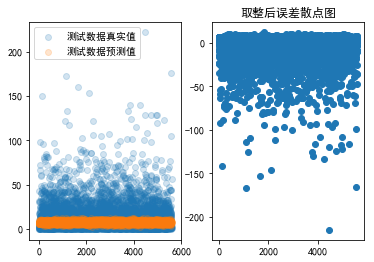

In [172]:
# SVR
clf_correct_larger_10=svm.SVR()
clf_correct_larger_10.fit(x_train_larger_10,y_train_larger_10)
joblib.dump(clf_correct_larger_10,'svr_correct_larger_10.asv')
printModelDeviation(clf_correct_larger_10.predict(x_test_larger_10),y_test_larger_10)

# 状态数据的猜想？
状态数据更可以利用时间序列分析的诸多方法来进行预测和模式识别，此前表现不好的LSTM网络可以派上用场，但此部分仅作为猜想